In [1]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as scistats
import statistics as stats
import seaborn as sns
from pathlib import Path

## Libraries, Helper Functions and High Level Variables

In [2]:
matplotlib.rcParams.update({'font.size': 12})

dir_path = Path(os.getcwd())
data_dir = str(os.path.join(dir_path,'data'))
balance_files = glob.glob(data_dir + "/poker_balances*.csv")
hands_files = glob.glob(data_dir + "/poker_hands*.csv")
table_files = glob.glob(data_dir + "/poker_table_info*.csv")

def get_hands_df():
    hands_dfs=[]

    for file in hands_files:
        new_df = pd.read_csv(file)
        hands_dfs.append(new_df)

    hands = pd.concat(hands_dfs)
    return hands
    
def get_games_df():
    balance_dfs=[]
    
    for file in balance_files:
        new_df = pd.read_csv(file)
        balance_dfs.append(new_df)
        
    balances = pd.concat(balance_dfs)
    return balances

def get_table_df():
    table_dfs=[]
    
    for file in table_files:
        new_df = pd.read_csv(file)
        table_dfs.append(new_df)
        
    tables = pd.concat(table_dfs)
    return tables


## Getting the Data and Augmentation

In [3]:
pd.set_option('display.max_columns', None)  
hands_base = get_hands_df()
games_base = get_games_df()
tables = get_table_df()

tables['category'] = np.where(tables['scenario_name'].str.startswith('smart'),'smart','conservative')

games = pd.merge(games_base,tables)
hands = pd.merge(hands_base,games)

## Data Samples

We have 3 individual tables: tables, games and hands.  They each represent different types of entities.  This will be explained per table.

### Table 

Our simulation software maps a scenario to a simulation, which in-turn runs a set of 2-6 players over 10 poker tables similar to simulation softwares concept of replications.  Each player within a scenario can have one of 3 personas: Smart Player, Conservative Player or Always Calls Player.  Smart Player runs a 100-card monte-carlo simulation everytime he has to make a betting decision, Conservative player ... and always calls player always calls no matter what happens.  Other types of player personas are implemented, but not used in this analysis.  We decided for this analysis to compare the smart player against the conservative player by having each player play 5 different scenarios against 1,2,3,4 and 5 always call type players. Than compare results between the two of them.  The Tables Dataframe below represents scenario and table level information eg simulation and replication info.

Fields:

* table_id -> replication id representing a poker table
* scenario_name -> represents the name of a simulation
* player_types -> a pipe delimited list of all player personas or types
* category -> if the table is part of the smart or conservative player analysis


In [4]:
tables.head(5)

table_id               scenario_name  \
0         1  smart vs 1 all call player   
0        10  smart vs 1 all call player   
0       100  smart vs 4 all call player   
0       101  smart vs 4 all call player   
0       102  smart vs 4 all call player   

                                        player_types category  
0                       AlwaysCallPlayer|SmartPlayer    smart  
0                       AlwaysCallPlayer|SmartPlayer    smart  
0  AlwaysCallPlayer|AlwaysCallPlayer|AlwaysCallPl...    smart  
0  AlwaysCallPlayer|AlwaysCallPlayer|AlwaysCallPl...    smart  
0  AlwaysCallPlayer|AlwaysCallPlayer|AlwaysCallPl...    smart

### Games

Each table is assigned a French-style poker deck of 52 cards, which it uses to play 100 sequential games of poker with.  It reshuffles the deck after each game.  The balances of the player are carried over between games.  The Games table contains the results of the games and the changes of each players balance as the 100 games progress.  It also records the overall outcome of the player within the game: won/lost and what the final hand would have been (straight, 2-pair, 3-pair etc).  The following information is contained in the Games Data Frame.

Fields:
* table_id -> a relational link to tables data frame representing the table or replication the row is associated with
* game_id -> an id representing one of 100 sequential games for a given table ordered chronologically.
* player_name -> name of the player usually player 1,2,3,4,5,6
* player_type -> the player personal or strategy used during the match
* game_result -> if the player won or lost the round
* game_reason -> did the player win or lose the match during the final hand or did he fold or alternatively was the only person that didn't fodl.
* blind type -> was the player the small or large blind
* beginning balance -> the players balance before joining the table.
* game_start_balance -> the player balance during the start of the poker game
* game_end_balance -> the player balance after the end of the poker game
* game_net_change -> the net change in players balance after the conclusion of the game
* scenario_name -> what scenario it belongs too
* player_types -> what player personas were involved in the game
* category -> what category smart or conservative player analysis dis this game belong to.


In [5]:
games.head(5)

table_id  game_id player_name  player_type game_result game_reason  \
0         1  1000001   players_1  SmartPlayer        lost   lost_game   
1         1  1000002   players_1  SmartPlayer        lost        fold   
2         1  1000003   players_1  SmartPlayer        lost        fold   
3         1  1000004   players_1  SmartPlayer        lost        fold   
4         1  1000005   players_1  SmartPlayer        lost        fold   

  blind_type final_hand  beginning_balance  game_start_balance  \
0      small   one_pair             100000            100000.0   
1        big       None             100000             99990.0   
2      small       None             100000             99980.0   
3        big       None             100000             99970.0   
4      small       None             100000             99960.0   

   game_end_balance  game_net_change               scenario_name  \
0           99990.0            -10.0  smart vs 1 all call player   
1           99980.0            -10.0  smart vs 1 all call player   
2           99970.0            -10.0  smart vs 1 all call player   
3           99960.0            -10.0  smart vs 1 all call player   
4           99950.0            -10.0  smart vs 1 all call player   

                   player_types category  
0  AlwaysCallPlayer|SmartPlayer    smart  
1  AlwaysCallPlayer|SmartPlayer    smart  
2  AlwaysCallPlayer|SmartPlayer    smart  
3  AlwaysCallPlayer|SmartPlayer    smart  
4  AlwaysCallPlayer|SmartPlayer    smart

### Hands

Each Game of poker is actually a set of up to 12 betting decisions per player.  3 for pre-flob, 3-card community, 4-card community and 5 card community post-flops.  A player can: call/check, raise or fold the hand.  Each row in the hands dataframe represents one of these betting decisions and provides all the information a player had when making the bet.  It also shows you the result of the bet.  Useful for stepping through the players action during a game.

Fields:
* table_id -> table associated with the bet
* game_id -> game associated with the bet
* player_name -> player name associated with the bet
* player_type -> player persona or strategy used during the bet
* bet_number -> for this specific game_id what bet number this is (1st bet, 2nd bet etc)
* opponents -> number of opponents left
* call -> how much the player needs to call to stay in the game
* current -> how much the player has in the pot right now
* pot -> how large the pot or reward is
* allowed -> if the player was allowed to raise or if it was the last round of bets
* hand1 -> first card in the players hand (of 2)
* hand2 -> the second card in the players hand (of 2)
* community1-5 -> 1-5 community card in the post flop

Everything after these fields are created from a joing to both table and game for convenice.

In [6]:
hands.head(5)

table_id  game_id player_name  player_type  bet_number  opponents  call  \
0         1  1000001   players_1  SmartPlayer           1          1   5.0   
1         1  1000001   players_1  SmartPlayer           2          1   0.0   
2         1  1000001   players_1  SmartPlayer           3          1   0.0   
3         1  1000001   players_1  SmartPlayer           4          1   0.0   
4         1  1000002   players_1  SmartPlayer           1          1   0.0   

   current  final   pot  allowed     hand1     hand2  community1  community2  \
0      5.0   10.0  15.0     True  6-spades  A-hearts       Z-N/A       Z-N/A   
1     10.0   10.0  20.0     True  6-spades  A-hearts  2-diamonds  4-diamonds   
2     10.0   10.0  20.0     True  6-spades  A-hearts  2-diamonds  4-diamonds   
3     10.0   10.0  20.0     True  6-spades  A-hearts  2-diamonds  4-diamonds   
4     10.0   10.0  20.0     True  5-hearts  A-spades       Z-N/A       Z-N/A   

  community3 community4 community5 game_result game_reason blind_type  \
0      Z-N/A      Z-N/A      Z-N/A        lost   lost_game      small   
1   6-hearts      Z-N/A      Z-N/A        lost   lost_game      small   
2   6-hearts   J-hearts      Z-N/A        lost   lost_game      small   
3   6-hearts   J-hearts   Q-hearts        lost   lost_game      small   
4      Z-N/A      Z-N/A      Z-N/A        lost        fold        big   

  final_hand  beginning_balance  game_start_balance  game_end_balance  \
0   one_pair             100000            100000.0           99990.0   
1   one_pair             100000            100000.0           99990.0   
2   one_pair             100000            100000.0           99990.0   
3   one_pair             100000            100000.0           99990.0   
4       None             100000             99990.0           99980.0   

   game_net_change               scenario_name                  player_types  \
0            -10.0  smart vs 1 all call player  AlwaysCallPlayer|SmartPlayer   
1            -10.0  smart vs 1 all call player  AlwaysCallPlayer|SmartPlayer   
2            -10.0  smart vs 1 all call player  AlwaysCallPlayer|SmartPlayer   
3            -10.0  smart vs 1 all call player  AlwaysCallPlayer|SmartPlayer   
4            -10.0  smart vs 1 all call player  AlwaysCallPlayer|SmartPlayer   

  category  
0    smart  
1    smart  
2    smart  
3    smart  
4    smart

# High Level Statistics - All Simulations

We provide a high-level aggregation across all simulations to provide context into the simulation software as a whole.  Since the simulation software is highly configurable, these high level statistics are useful for gauging things like performance or to catch anomalies.

In [7]:
player_final_hands = hands.query('community5 != "Z-N/A"').groupby(['table_id','game_id','player_name','hand1','hand2','community1','community2','community3','community4','community5','final_hand']).count().game_result.reset_index().groupby('final_hand').game_id.count().reset_index()
player_final_hands_type, player_final_hands_type_numbers = list(zip(*player_final_hands.values))
player_final_hands_type = ['player final _hand' + card for card in player_final_hands_type]

winning_hands = games.query('game_result == "won"').groupby(['game_id','final_hand']).count().groupby('final_hand').count().reset_index()[['final_hand','table_id']]
winning_hand_type, winning_hand_type_numbers = list(zip(*winning_hands.values))
winning_hand_type = ['won by ' + card for card in winning_hand_type]

simulation_overview = pd.DataFrame(
    data={
            "Metric":[
                "scenarios",
                "player strategies",
                "active players",
                "player - bet decisions",
                "tables",
                "games", 
                "average chip gain/loss",
                "average pot size",
                "unique 2-card combos",
                "unique end combos",
                "unique 3-card flops",
                "unique 4-card flops",
                "unique 5-card flops"
            ] + list(player_final_hands_type) +
                list(winning_hand_type),
            "Total":[
                tables.scenario_name.nunique(),
                games.player_type.nunique(),
                games.groupby(['table_id','player_name']).game_result.count().reset_index().shape[0],
                hands.shape[0],
                tables.table_id.nunique(),
                games.groupby(['table_id', 'game_id']).ngroups,
                round(games.game_net_change.mean(),0),
                round(hands.pot.mean(),0),
                hands.groupby(['hand1','hand2']).count().reset_index().shape[0],
                hands.query('community5 != "Z-N/A"').groupby(['hand1','hand2','community1','community2','community3','community4','community5']).count().reset_index().shape[0],
                hands.query('community1 != "Z-N/A"').groupby(['community1','community2','community3']).count().reset_index().shape[0],
                hands.query('community4 != "Z-N/A"').groupby(['community1','community2','community3','community4']).count().reset_index().shape[0],
                hands.query('community5 != "Z-N/A"').groupby(['community1','community2','community3','community4','community5']).count().reset_index().shape[0]
            ] + list(player_final_hands_type_numbers) +
                list(winning_hand_type_numbers)
    },
    columns = ['Metric','Total']
)

simulation_overview

Metric     Total
0                          scenarios      10.0
1                  player strategies       3.0
2                     active players    1200.0
3             player - bet decisions  739816.0
4                             tables     300.0
5                              games   30000.0
6             average chip gain/loss       0.0
7                   average pot size     404.0
8               unique 2-card combos    1404.0
9                  unique end combos   93038.0
10               unique 3-card flops   21989.0
11               unique 4-card flops   43177.0
12               unique 5-card flops   26070.0
13            player final _handNone    1448.0
14           player final _handflush    2942.0
15    player final _handfour_of_kind     182.0
16      player final _handfull_house    2552.0
17       player final _handhigh_card   15101.0
18        player final _handone_pair   39499.0
19        player final _handstraight    4320.0
20  player final _handstraight_flush      33.0
21   player final _handthree_of_kind    4728.0
22        player final _handtwo_pair   22234.0
23                      won by flush    2201.0
24               won by four_of_kind     168.0
25                 won by full_house    2092.0
26                  won by high_card    1133.0
27                   won by one_pair    8614.0
28                   won by straight    3301.0
29             won by straight_flush      30.0
30              won by three_of_kind    2930.0
31                   won by two_pair    9531.0

# Performance over all Games by Player Type

Below we provide a reference for all replications (tables) within each scenario by averaging the mean net change in each persons chips over all games as well as variance and standard deviation.  We also report the players, lowest and highest balances.

In [8]:
table_level_statistics = games.groupby(['category','scenario_name','table_id','player_name','player_type']).agg({
    "game_net_change":[np.mean,lambda col: np.var(col,ddof=1),'count'],
    "game_end_balance":[np.min,np.max]
}).reset_index().sort_values(['table_id','player_name'])

table_level_statistics.columns = ['category','scenario_name','table_id','player_name','player_type','table_mean','table_variance','count','player_lowest_balance','player_highest_balance']
table_level_statistics['confidence_interval'] = table_level_statistics.apply(lambda df: scistats.t.interval(alpha=.99,df=df['count'],loc=df['table_mean'],scale=np.sqrt(df['table_variance'])/np.sqrt(df['count'])),axis=1)
table_level_statistics['lower_bound_95%'], table_level_statistics['upper_bound_95%'] = zip(*table_level_statistics.confidence_interval)
table_level_statistics.pop('confidence_interval')
table_level_statistics



category                      scenario_name  table_id player_name  \
600         smart         smart vs 1 all call player         1   players_1   
601         smart         smart vs 1 all call player         1   players_2   
602         smart         smart vs 1 all call player         2   players_1   
603         smart         smart vs 1 all call player         2   players_2   
604         smart         smart vs 1 all call player         3   players_1   
..            ...                                ...       ...         ...   
595  conservative  conservative vs 5 all call player       300   players_2   
596  conservative  conservative vs 5 all call player       300   players_3   
597  conservative  conservative vs 5 all call player       300   players_4   
598  conservative  conservative vs 5 all call player       300   players_5   
599  conservative  conservative vs 5 all call player       300   players_6   

          player_type  table_mean  table_variance  count  \
600       SmartPlayer   77.000000    4.518081e+04    100   
601  AlwaysCallPlayer  -77.000000    4.518081e+04    100   
602       SmartPlayer   97.400000    4.275883e+04    100   
603  AlwaysCallPlayer  -97.400000    4.275883e+04    100   
604       SmartPlayer   47.500000    3.612197e+04    100   
..                ...         ...             ...    ...   
595  AlwaysCallPlayer -292.515000    5.104472e+06    100   
596  AlwaysCallPlayer -297.623333    5.101221e+06    100   
597  AlwaysCallPlayer -279.440000    5.111810e+06    100   
598  AlwaysCallPlayer -275.998333    5.113841e+06    100   
599  AlwaysCallPlayer  131.996667    1.355548e+07    100   

     player_lowest_balance  player_highest_balance  lower_bound_95%  \
600           99950.000000           108350.000000        21.184655   
601           91650.000000           100050.000000      -132.815345   
602           99990.000000           109740.000000        43.101290   
603           90260.000000           100010.000000      -151.698710   
604           99990.000000           104790.000000        -2.407099   
..                     ...                     ...              ...   
595           70588.500000           100150.000000      -885.784518   
596           70237.666667           100005.000000      -890.703911   
597           72031.000000            99990.000000      -873.135759   
598           72305.166667           100085.000000      -869.812079   
599           99995.000000           135171.666667      -834.797732   

     upper_bound_95%  
600       132.815345  
601       -21.184655  
602       151.698710  
603       -43.101290  
604        97.407099  
..               ...  
595       300.754518  
596       295.457244  
597       314.255759  
598       317.815412  
599      1098.791066  

[1200 rows x 12 columns]

Below graph, we look at all 10 of our scenarios by player.  The top 10 graphs represent our conservative scenarios in descending order of number of players.  The bottom 10 scenarios show Smart Player in descending number of opponents.  You can see that Smart Player shifts right as more players are added, while his opponents tend to lose about the same amount of chips per table.  This is due to the fact that the always call opponents make the same type of decisions and lose about the same percent of the time, but the smart player gets to reap the benefits of those calls by on average winning a larger parts due to more contributors.

Text(0.05, 0.5, 'Number of Games')

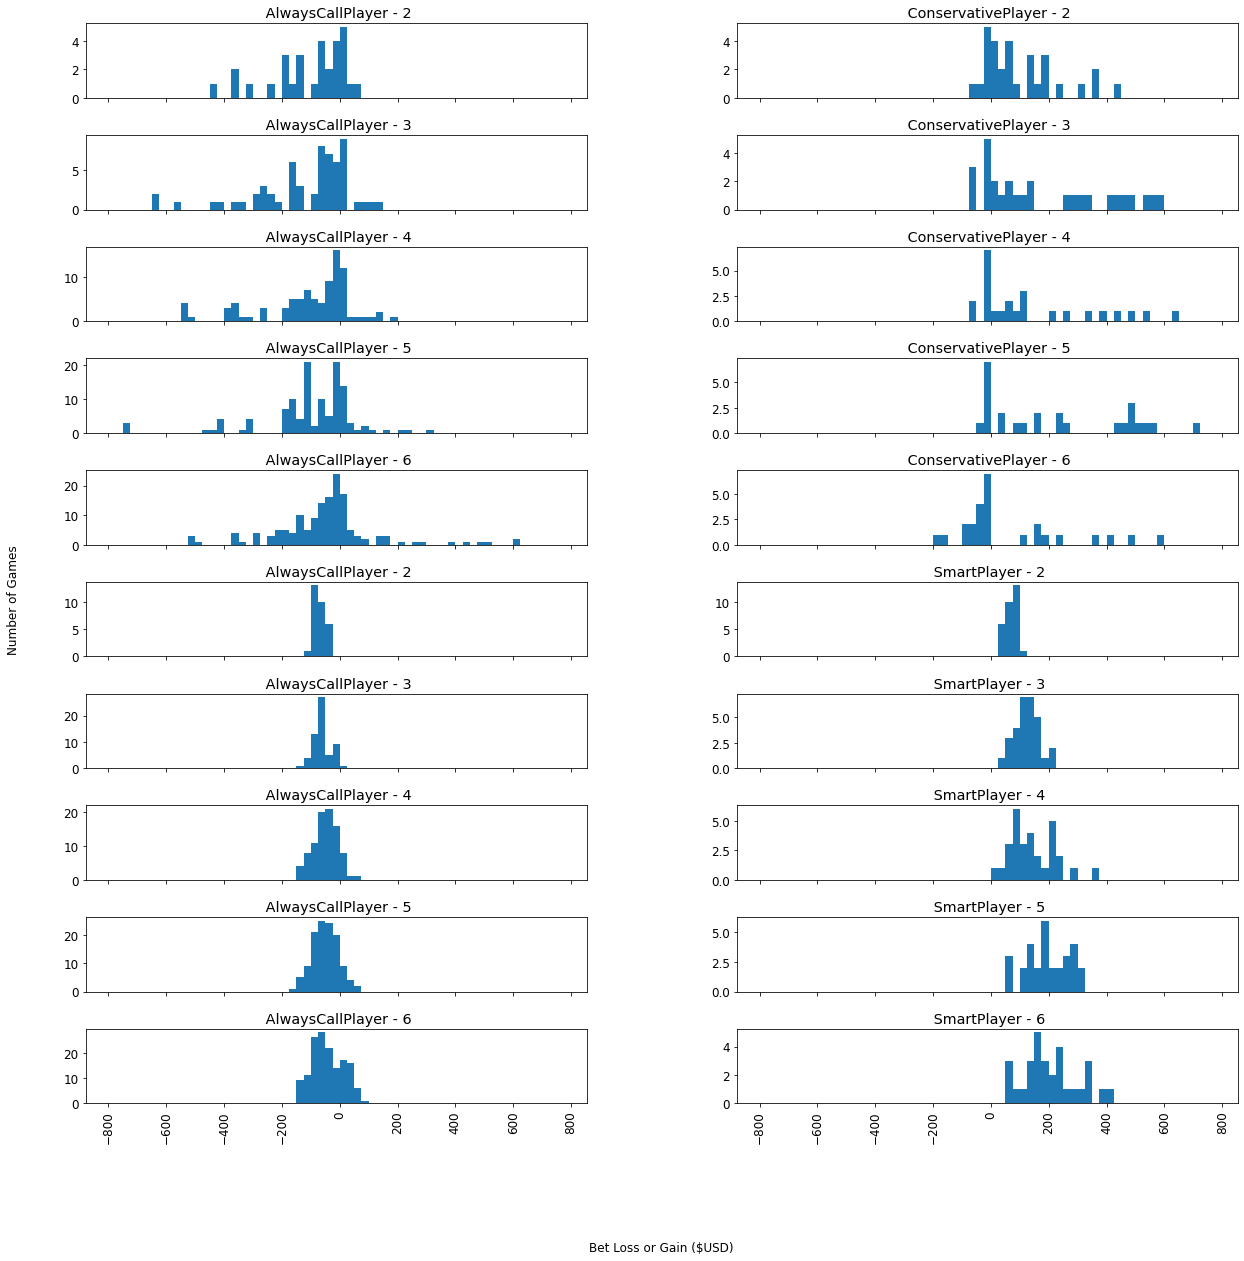

In [9]:
fig, axis = plt.subplots(10,2,figsize=(20, 20), sharex = True)

table_level_statistics.hist(
        column='table_mean',
        by=['scenario_name','player_type'],
        grid = True,
        bins = list(range(-800,800,25)),
        ax = axis
)

for row in axis:
    for col in row:
        player_name = col.title.get_text().split(',')[1]
        players_involved = int(''.join(i for i in col.title.get_text().split(',')[0] if i.isdigit())) + 1
        graph_title = player_name[:-1] + ' - ' + str(players_involved)
        col.set_title(graph_title)

fig.text(0.5,0.05, "Bet Loss or Gain ($USD)", ha="center", va="center")
fig.text(0.05,0.5, "Number of Games", ha="center", va="center", rotation=90)


We can also look at the mean, variance and standard deviation of players across all games within a scenario.  Sometimes interesting patterns emerge.

In [10]:
pd.options.display.float_format = '{:.5f}'.format

game_level_statistics = games.groupby(['category','scenario_name','player_name','player_type']).agg({
    "game_net_change":[np.mean,lambda col: np.var(col,ddof=1)],
    "game_end_balance":[np.min,np.max]
}).reset_index().sort_values(['player_name'])

game_level_statistics.columns = ['category','scenario_name','player_name','player_type','game_mean','game_variance','min_balance','max_balance']

game_level_statistics.sort_values(['player_type','scenario_name'],ascending=False)

category                      scenario_name player_name  \
34         smart         smart vs 5 all call player   players_1   
29         smart         smart vs 4 all call player   players_1   
25         smart         smart vs 3 all call player   players_1   
22         smart         smart vs 2 all call player   players_1   
20         smart         smart vs 1 all call player   players_1   
14  conservative  conservative vs 5 all call player   players_1   
9   conservative  conservative vs 4 all call player   players_1   
5   conservative  conservative vs 3 all call player   players_1   
2   conservative  conservative vs 2 all call player   players_1   
0   conservative  conservative vs 1 all call player   players_1   
35         smart         smart vs 5 all call player   players_2   
36         smart         smart vs 5 all call player   players_3   
37         smart         smart vs 5 all call player   players_4   
38         smart         smart vs 5 all call player   players_5   
39         smart         smart vs 5 all call player   players_6   
30         smart         smart vs 4 all call player   players_2   
31         smart         smart vs 4 all call player   players_3   
32         smart         smart vs 4 all call player   players_4   
33         smart         smart vs 4 all call player   players_5   
26         smart         smart vs 3 all call player   players_2   
27         smart         smart vs 3 all call player   players_3   
28         smart         smart vs 3 all call player   players_4   
23         smart         smart vs 2 all call player   players_2   
24         smart         smart vs 2 all call player   players_3   
21         smart         smart vs 1 all call player   players_2   
15  conservative  conservative vs 5 all call player   players_2   
16  conservative  conservative vs 5 all call player   players_3   
17  conservative  conservative vs 5 all call player   players_4   
18  conservative  conservative vs 5 all call player   players_5   
19  conservative  conservative vs 5 all call player   players_6   
10  conservative  conservative vs 4 all call player   players_2   
11  conservative  conservative vs 4 all call player   players_3   
12  conservative  conservative vs 4 all call player   players_4   
13  conservative  conservative vs 4 all call player   players_5   
6   conservative  conservative vs 3 all call player   players_2   
7   conservative  conservative vs 3 all call player   players_3   
8   conservative  conservative vs 3 all call player   players_4   
3   conservative  conservative vs 2 all call player   players_2   
4   conservative  conservative vs 2 all call player   players_3   
1   conservative  conservative vs 1 all call player   players_2   

           player_type  game_mean  game_variance  min_balance  max_balance  
34         SmartPlayer  206.33000   868629.37422  97270.00000 141790.00000  
29         SmartPlayer  197.08667   645453.39325  95375.00000 132085.00000  
25         SmartPlayer  145.58500   358168.85943  98060.00000 135686.66667  
22         SmartPlayer  124.16667   184004.57375  98150.00000 121170.00000  
20         SmartPlayer   69.57833    43512.50136  98940.00000 110130.00000  
14  ConservativePlayer  245.74533 21609152.10318  81432.00000 334524.00000  
9   ConservativePlayer  368.93617 20505282.00168  93140.00000 268755.00000  
5   ConservativePlayer  330.27100 24190141.08525  91257.00000 258130.00000  
2   ConservativePlayer  241.15833 10061270.43274  92702.00000 225035.00000  
0   ConservativePlayer  103.92033  1916380.66621  93397.00000 143162.00000  
35    AlwaysCallPlayer  -50.60800   230236.28643  86832.00000 108110.00000  
36    AlwaysCallPlayer  -46.80633   223168.37562  86882.00000 107190.00000  
37    AlwaysCallPlayer  -40.72800   236618.18008  85022.00000 109390.00000  
38    AlwaysCallPlayer  -28.34633   268994.28582  86330.00000 108820.00000  
39    AlwaysCallPlayer  -39.84133   240205.84744  84990.00000 111350.00000  
30    AlwaysCallPlayer  -46.

The overall game end balance is sequential, so it's a bit misleading to graph it as a box plot since each observation is not independent.  That said, the patterns in the distributions of end balances do have interesting properties in terms of ranges, mean and quartile that create an interesting observation.  Smart player's average is higher than 75% quantile of the All Call Players with the bottom of his range being about as bad as the mean of the all call players.  Smart playres end balance has significant amount of outliers sometimes 30% or more from the starting balanace.  The end balance for all call player tends to be lower, but not so drastic as the smart player.  partially due to the fact that in multiplayer games, Smart player can collect from many Always call players mitigating the damage.

[Text(1, 0, 'always call player - conservative scenario'),
 Text(2, 0, 'always call player - smart scenario'),
 Text(3, 0, 'conservative player - conservative scenario'),
 Text(4, 0, 'smart player - smart scenario')]

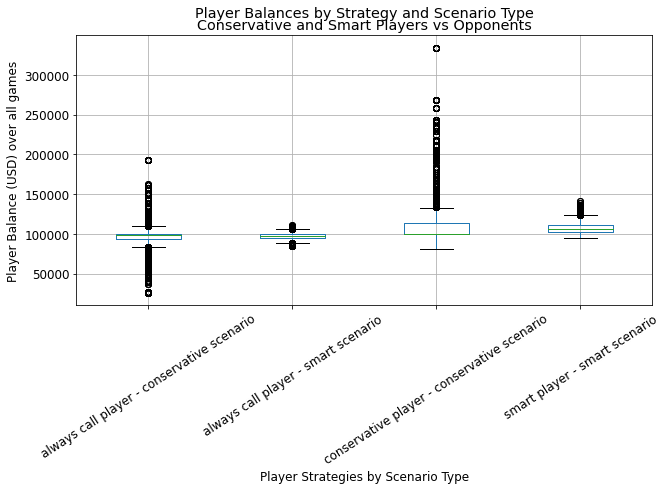

In [11]:
axis = games.boxplot(
        column=['game_end_balance'],
        by=['player_type','category'],
        figsize=(10,5),
        rot=33
)

plt.suptitle("Player Balances by Strategy and Scenario Type")
axis.set_title('Conservative and Smart Players vs Opponents')
axis.set_ylabel('Player Balance (USD) over all games')
axis.set_xlabel('Player Strategies by Scenario Type')

axis_replace={
    'AlwaysCallPlayer': 'always call player',
    'SmartPlayer': 'smart player',
    'ConservativePlayer': 'conservative player'
}

axis_cat_labels = [ax.get_text()[1:-1].split(',') for ax in axis.get_xmajorticklabels()]
axis_cat_labels = [axis_replace[ax[0]] + ' -' + ax[1] + ' scenario' for ax in axis_cat_labels]
axis.set_xticklabels(axis_cat_labels)


# Performance of Player Balances over Time

We provide the time series we used for the player balance over 100 games.  We included all 10 scenarios here.  The game_id is mapped sequentially from 1-100.  Table id is uniquely mapped as well.  On average, the player balance for smart player increases dramatically at the expense of all call players.

In [12]:
time_series = games[['category','scenario_name','player_name','player_type','table_id','game_id','game_end_balance']]
time_series['game_id'] = (time_series['game_id'] - 1) % 100
time_series['table_id'] = (time_series['table_id'] - 1) % 10
time_series = time_series.pivot_table(index=['category','scenario_name','player_name','player_type','table_id'],columns=['game_id'],values='game_end_balance').reset_index()
time_series

c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


game_id      category                      scenario_name player_name  \
0        conservative  conservative vs 1 all call player   players_1   
1        conservative  conservative vs 1 all call player   players_1   
2        conservative  conservative vs 1 all call player   players_1   
3        conservative  conservative vs 1 all call player   players_1   
4        conservative  conservative vs 1 all call player   players_1   
..                ...                                ...         ...   
395             smart         smart vs 5 all call player   players_6   
396             smart         smart vs 5 all call player   players_6   
397             smart         smart vs 5 all call player   players_6   
398             smart         smart vs 5 all call player   players_6   
399             smart         smart vs 5 all call player   players_6   

game_id         player_type  table_id            0            1            2  \
0        ConservativePlayer         0  99995.00000  99985.00000  99980.00000   
1        ConservativePlayer         1  99995.00000  99985.00000  99980.00000   
2        ConservativePlayer         2  99995.00000  99985.00000  99980.00000   
3        ConservativePlayer         3  99995.00000  99985.00000  99980.00000   
4        ConservativePlayer         4  99995.00000  99985.00000  99980.00000   
..                      ...       ...          ...          ...          ...   
395        AlwaysCallPlayer         5  99956.66667  99680.00000  99456.66667   
396        AlwaysCallPlayer         6 100776.66667 100533.33333 100266.66667   
397        AlwaysCallPlayer         7  99756.66667  99533.33333  99876.66667   
398        AlwaysCallPlayer         8  99856.66667  99666.66667  99676.66667   
399        AlwaysCallPlayer         9 100030.00000  99753.33333  99576.66667   

game_id            3            4            5            6            7  \
0        99970.00000  99963.33333  99953.33333  99948.33333  99938.33333   
1        99970.00000  99965.00000  99955.00000 101268.00000 101258.00000   
2        99970.00000  99963.33333  99953.33333  99948.33333  99938.33333   
3        99970.00000  99965.00000  99955.00000  99950.00000  99940.00000   
4       100310.00000 100305.00000 100295.00000 100290.00000 100280.00000   
..               ...          ...          ...          ...          ...   
395      99200.00000  98823.33333  98613.33333  98303.33333  98193.33333   
396     100130.00000 100626.66667 101636.66667 101626.66667 102843.33333   
397      99753.33333  99710.00000  99453.33333  99386.66667  99320.00000   
398      99333.33333  99323.33333  99080.00000  98975.00000  98765.00000   
399     100606.66667 100330.00000 100350.00000 100140.00000 100063.33333   

game_id            8            9           10           11           12  \
0        99933.33333  99923.33333  99918.33333  99908.33333  99903.33333   
1       101253.00000 101243.00000 101238.00000 101228.00000 101223.00000   
2        99933.33333  99923.33333  99918.33333  99908.33333  99903.33333   
3        99935.00000  99925.00000  99920.00000  99910.00000  99905.00000   
4       100275.00000 100265.00000 100260.00000 100250.00000 100245.00000   
..               ...          ...          ...          ...          ...   
395      98183.33333  98370.00000  98326.66667  98326.66667  99136.66667   
396     102566.66667 102090.00000 102176.66667 103540.00000 103463.33333   
397     100163.33333  99953.33333  99876.66667  99840.00000  99496.66667   
398      98621.66667  98578.33333  98535.00000  98491.66667  99268.33333   
399      99986.66667  99976.66667  99933.33333  99723.33333  99700.00000   

game_id           13           14           15           16           17  \
0        99893.33333  99888.33333  99878.33333  99873.33333  99863.33333   
1       101213.00000 101206.33333 101196.33333 101191.33333 101181.33333   
2        99893.33333  99888.33333  99878.33333  99873.33333  99863.33333   
3        99895.00000  99890.00000  99880.000

Below we provide per game confidence intervals for each player in each scenario category: conservative vs smart player.  Here you can look into the data about how poker players did relatively to the number of games played.

In [13]:
time_series = games[['category','player_type','game_id','game_end_balance']]
time_series['game_id'] = (time_series['game_id'] - 1) % 100
time_series_stats = time_series.groupby(['category','player_type','game_id']).agg(
    {'game_end_balance':[
        ['mean',np.mean],
        ['sample_var',lambda col: np.var(col,ddof=1)],
        ['N','count']]
    }
).reset_index()

time_series_stats.columns = ['category','player_type','game_id','mean','sample_var','N']
time_series_stats['confidence_interval'] = time_series_stats.apply(lambda df: scistats.norm.interval(alpha=.95, loc=df['mean'],scale=np.sqrt(df['sample_var'])/np.sqrt(df['N'])),axis=1)
time_series_stats['lower_bound_95%'], time_series_stats['upper_bound_95%'] = zip(*time_series_stats.confidence_interval)
time_series_stats.pop('confidence_interval')
time_series_stats

c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


category       player_type  game_id         mean     sample_var    N  \
0    conservative  AlwaysCallPlayer        0  99919.66667   659345.43430  450   
1    conservative  AlwaysCallPlayer        1  99900.80000   778346.12918  450   
2    conservative  AlwaysCallPlayer        2  99818.14667  1823716.68371  450   
3    conservative  AlwaysCallPlayer        3  99664.25778  5335291.83281  450   
4    conservative  AlwaysCallPlayer        4  99627.65778  5594435.45760  450   
..            ...               ...      ...          ...            ...  ...   
395         smart       SmartPlayer       95 114305.63333 68232870.56935  150   
396         smart       SmartPlayer       96 114497.86667 68695947.20805  150   
397         smart       SmartPlayer       97 114542.86667 67725772.15213  150   
398         smart       SmartPlayer       98 114666.66667 68818553.13199  150   
399         smart       SmartPlayer       99 114854.93333 70678140.04027  150   

     lower_bound_95%  upper_bound_95%  
0        99844.64299      99994.69034  
1        99819.28675      99982.31325  
2        99693.37369      99942.91964  
3        99450.84475      99877.67080  
4        99409.12330      99846.19226  
..               ...              ...  
395     112983.73126     115627.53540  
396     113171.48650     115824.24683  
397     113225.88586     115859.84747  
398     113339.10339     115994.22994  
399     113509.55318     116200.31349  

[400 rows x 8 columns]

This graphic shows you the mean balance between all player classes within the conservative and smart player types as well as the 95th confidence interval for ending player balance over time.  As you can see, Smart Player does well at the expense of the all call players.  He seems to do so at a relatively consistent rate.

c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


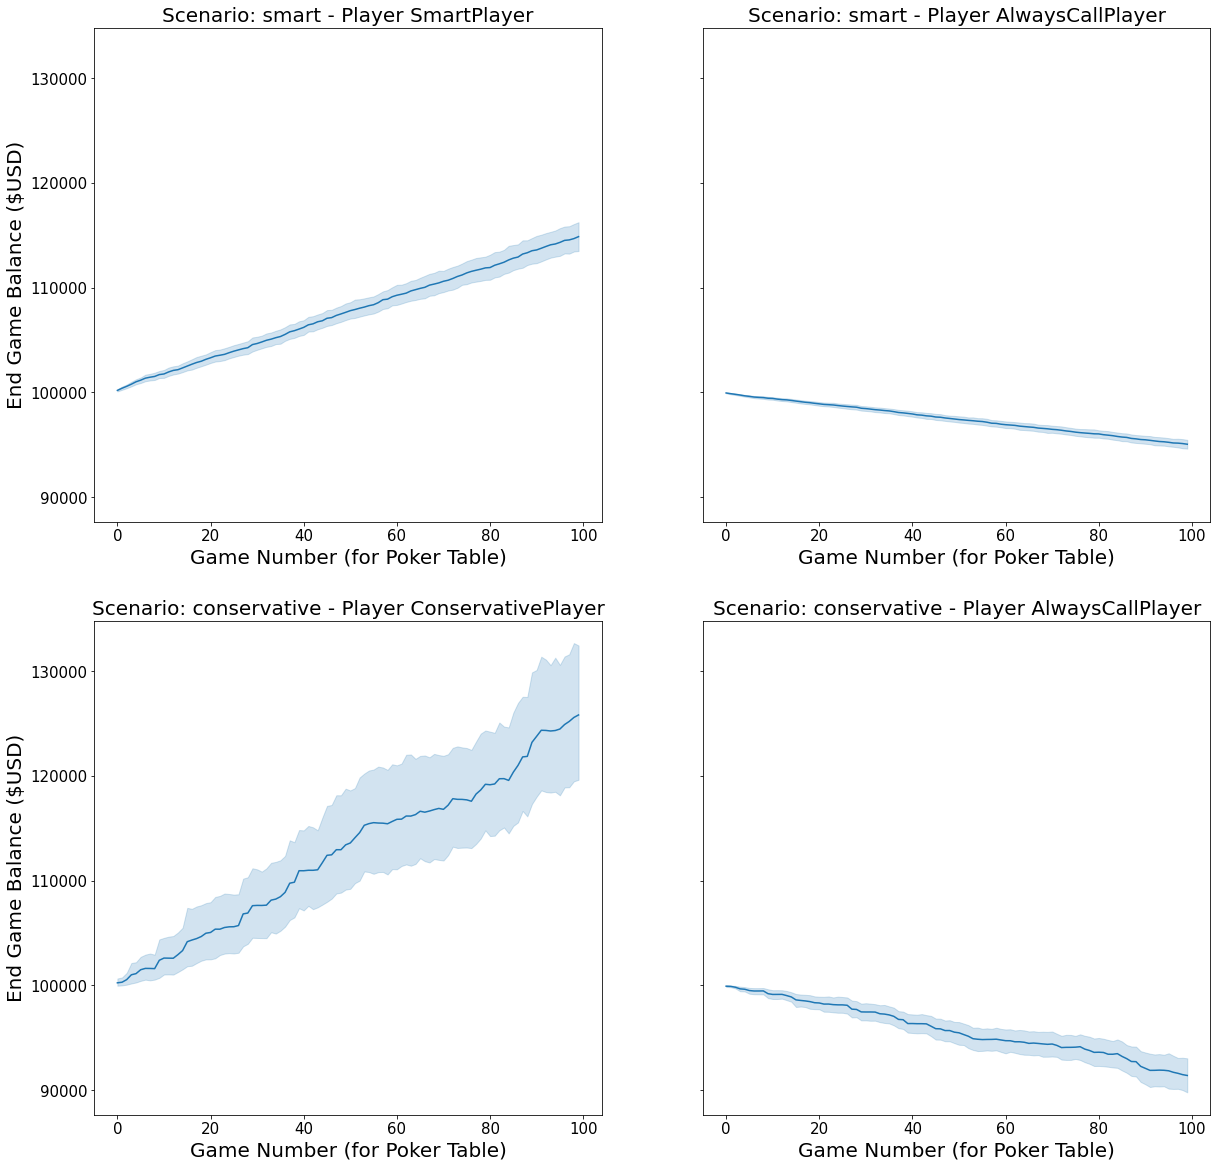

In [14]:
fig, axis = plt.subplots(2,2,figsize=(20, 20),sharey=True)

time_series = games[['category','player_type','game_id','game_end_balance']]
time_series['game_id'] = (time_series['game_id'] - 1) % 100

all_axis = []

for row in axis:
    for col in row:
        all_axis.append(col)
        
        
categories_to_plot = time_series[['category','player_type']].drop_duplicates()

plot_num = 0
for index, row in categories_to_plot.iterrows():
    ax = all_axis[plot_num]
    plot_num += 1
    player_type, category = row['player_type'], row['category']
    query_filter = 'player_type == "{}" and category == "{}"'.format(player_type,category)
    plot_data = time_series.query(query_filter)
    sns.lineplot(x=plot_data['game_id'],y=plot_data['game_end_balance'],ax=ax)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title('Scenario: {} - Player {}'.format(category,player_type),fontsize=20)
    ax.set_ylabel('End Game Balance ($USD)',fontsize=20)
    ax.set_xlabel('Game Number (for Poker Table)',fontsize=20)



c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


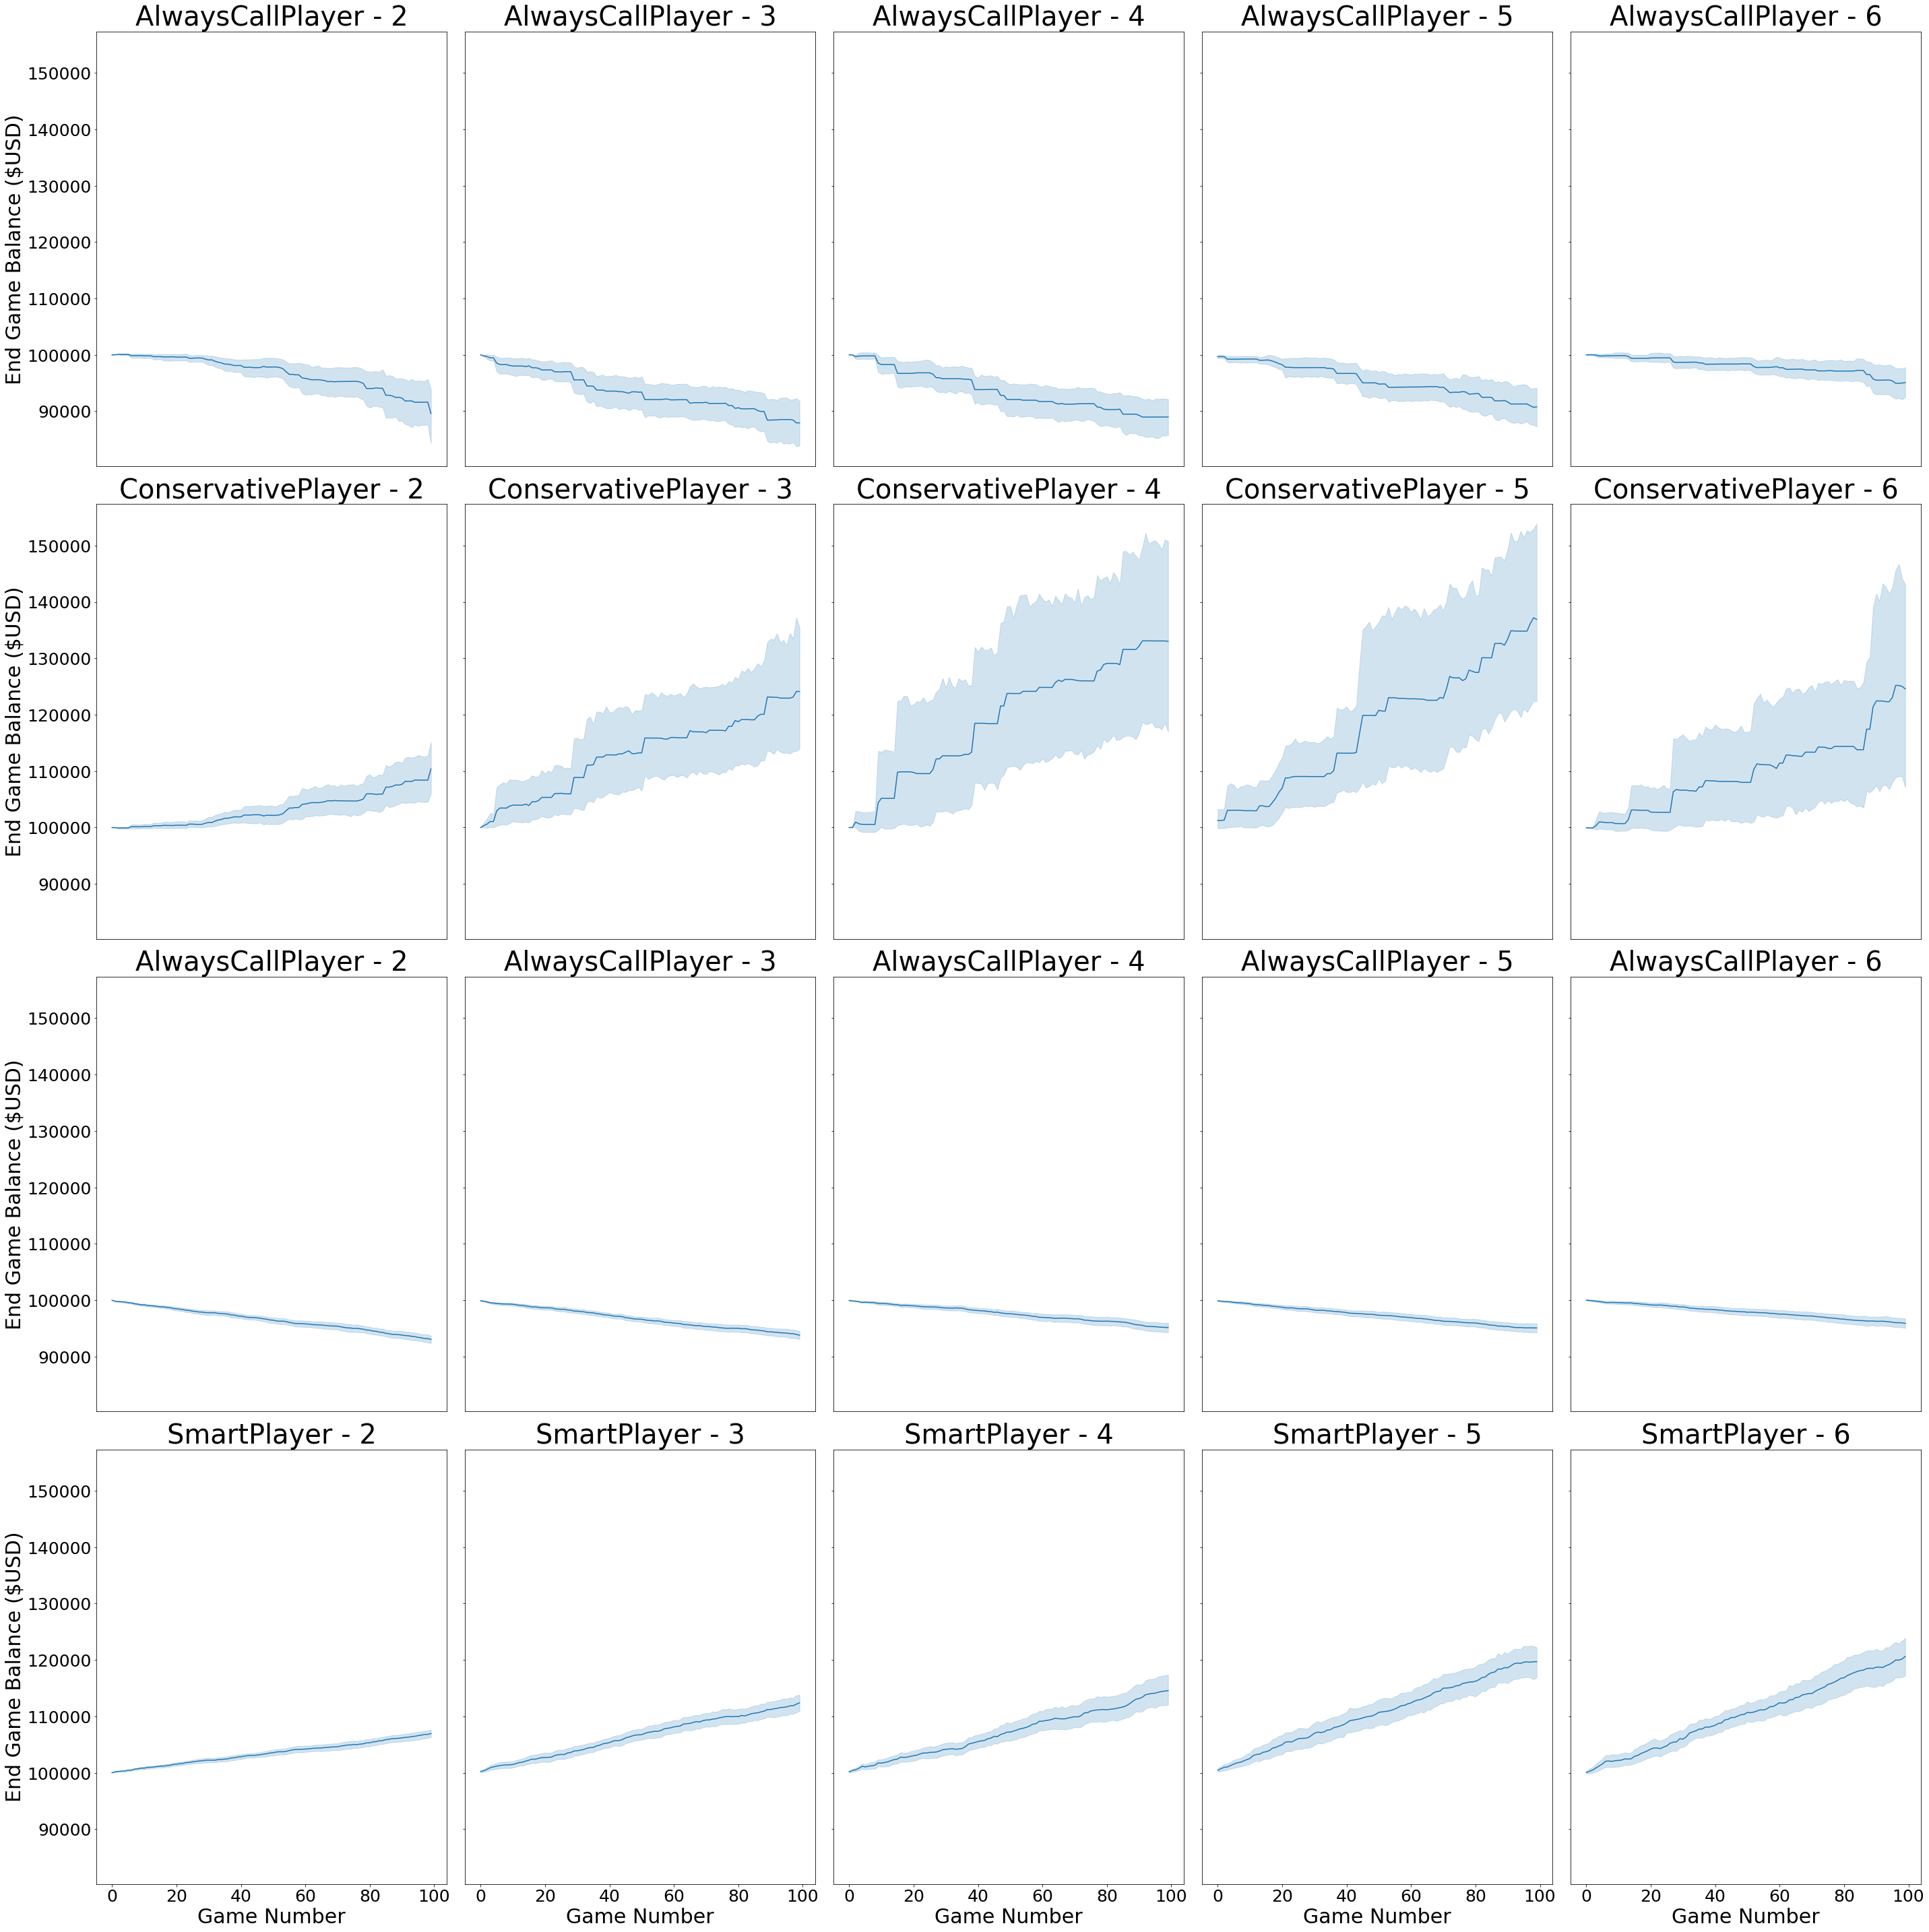

In [15]:
fig, axis = plt.subplots(4,5,figsize=(40, 40),sharey=True)

time_series = games[['category','scenario_name','player_type','game_id','game_end_balance']]
time_series['game_id'] = (time_series['game_id'] - 1) % 100

all_axis = []

for row in axis:
    for col in row:
        all_axis.append(col)
        
categories_to_plot = time_series[['category','scenario_name','player_type']].drop_duplicates()
categories_to_plot['sort_order'] =  categories_to_plot.scenario_name.str.extract('(\d+)')
categories_to_plot = categories_to_plot.sort_values(['category','player_type','sort_order'])

plot_num = 0
for index, row in categories_to_plot.iterrows():
    ax = all_axis[plot_num]
    plot_num += 1
    player_type, category, scenario_name, number = row['player_type'], row['category'], row['scenario_name'], row['sort_order']
    query_filter = 'player_type == "{}" and category == "{}" and scenario_name == "{}"'.format(player_type,category,scenario_name)
    plot_data = time_series.query(query_filter)
    sns.lineplot(x=plot_data['game_id'],y=plot_data['game_end_balance'],ax=ax)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    if plot_num > 15:
        ax.set_xlabel('Game Number',fontsize=30)
    else:
        ax.get_xaxis().set_visible(False)
    ax.set_title('{} - {}'.format(player_type,int(number) + 1),fontsize=40)
    ax.set_ylabel('End Game Balance ($USD)',fontsize=30)
    

plt.tight_layout()

# Analysis of 2 Card Games, Flob and River performance

In [16]:
pre_flop_hands = hands.query('community1 == "Z-N/A" and bet_number == "1"')
analysis_data = pre_flop_hands[['category','player_type','opponents','hand1','hand2','game_reason','game_net_change']]
analysis_data[['rank1', 'suit1']] = analysis_data['hand1'].str.split('-', 1, expand=True)
analysis_data[['rank2', 'suit2']] = analysis_data['hand2'].str.split('-', 1, expand=True)
analysis_data['same_suit'] = analysis_data['suit1'] == analysis_data['suit2']
analysis_data

C:\Users\Silbe\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


category       player_type  opponents       hand1       hand2  \
0         smart       SmartPlayer          1    6-spades    A-hearts   
4         smart       SmartPlayer          1    5-hearts    A-spades   
8         smart       SmartPlayer          1  2-diamonds    5-hearts   
10        smart       SmartPlayer          1    3-hearts  J-diamonds   
14        smart       SmartPlayer          1     4-clubs    A-hearts   
...         ...               ...        ...         ...         ...   
739792    smart  AlwaysCallPlayer          4  2-diamonds    9-hearts   
739796    smart  AlwaysCallPlayer          4    K-hearts     A-clubs   
739800    smart  AlwaysCallPlayer          4    8-spades    J-hearts   
739806    smart  AlwaysCallPlayer          4    6-hearts   10-spades   
739810    smart  AlwaysCallPlayer          4    4-spades  7-diamonds   

       game_reason  game_net_change rank1     suit1 rank2     suit2  same_suit  
0        lost_game        -10.00000     6    spades     A    hearts      False  
4             fold        -10.00000     5    hearts     A    spades      False  
8             fold        -10.00000     2  diamonds     5    hearts      False  
10            fold        -10.00000     3    hearts     J  diamonds      False  
14            fold        -10.00000     4     clubs     A    hearts      False  
...            ...              ...   ...       ...   ...       ...        ...  
739792   lost_game        -10.00000     2  diamonds     9    hearts      False  
739796   lost_game        -10.00000     K    hearts     A     clubs      False  
739800   lost_game       -210.00000     8    spades     J    hearts      False  
739806   lost_game        -10.00000     6    hearts    10    spades      False  
739810    won_game        840.00000     4    spades     7  diamonds      False  

[120000 rows x 12 columns]

<AxesSubplot:>

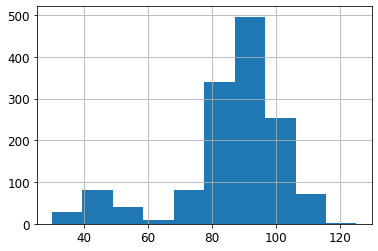

In [17]:
analysis_data.groupby(['hand1','hand2']).game_reason.count().hist()

In [18]:
per_game_type = analysis_data.groupby(['rank1','rank2','game_reason']).category.count().reset_index()
games_total = analysis_data.groupby(['rank1','rank2']).game_net_change.count().reset_index()
pre_flop_data = pd.merge(per_game_type,games_total).sort_values(['rank1','rank2'])
game_stats = pre_flop_data.pivot(index =['rank1','rank2','game_net_change'], columns = ['game_reason'], values =['category']).reset_index()
game_stats.columns = [c[1] if c[1] else c[0] for c in game_stats.columns]
game_stats = game_stats.fillna(0)
game_stats['fold_percent'] = game_stats['fold'] / game_stats['game_net_change']
game_stats['last_man_standing_percent'] = game_stats['last_man_standing'] / game_stats['game_net_change']
game_stats['lost_game_percent'] = game_stats['lost_game'] / game_stats['game_net_change']
game_stats['won_game_percent'] = game_stats['won_game'] / game_stats['game_net_change']
game_stats

rank1 rank2  game_net_change  fold  last_man_standing  lost_game  won_game  \
0     10    10              540    58                 24        235       223   
1     10     A             1483   248                 38        748       449   
2     10     J             1430   251                 37        737       405   
3     10     K             1433   257                 48        710       418   
4     10     Q             1418   259                 45        705       409   
..   ...   ...              ...   ...                ...        ...       ...   
86     K     A             1495   256                 38        654       547   
87     K     K              558    11                 17        220       310   
88     Q     A             1411   250                 46        644       471   
89     Q     K             1467   255                 49        635       528   
90     Q     Q              531    29                 10        237       255   

    fold_percent  last_man_standing_percent  lost_game_percent  \
0        0.10741                    0.04444            0.43519   
1        0.16723                    0.02562            0.50438   
2        0.17552                    0.02587            0.51538   
3        0.17934                    0.03350            0.49546   
4        0.18265                    0.03173            0.49718   
..           ...                        ...                ...   
86       0.17124                    0.02542            0.43746   
87       0.01971                    0.03047            0.39427   
88       0.17718                    0.03260            0.45641   
89       0.17382                    0.03340            0.43286   
90       0.05461                    0.01883            0.44633   

    won_game_percent  
0            0.41296  
1            0.30276  
2            0.28322  
3            0.29170  
4            0.28843  
..               ...  
86           0.36589  
87           0.55556  
88           0.33381  
89           0.35992  
90           0.48023  

[91 rows x 11 columns]

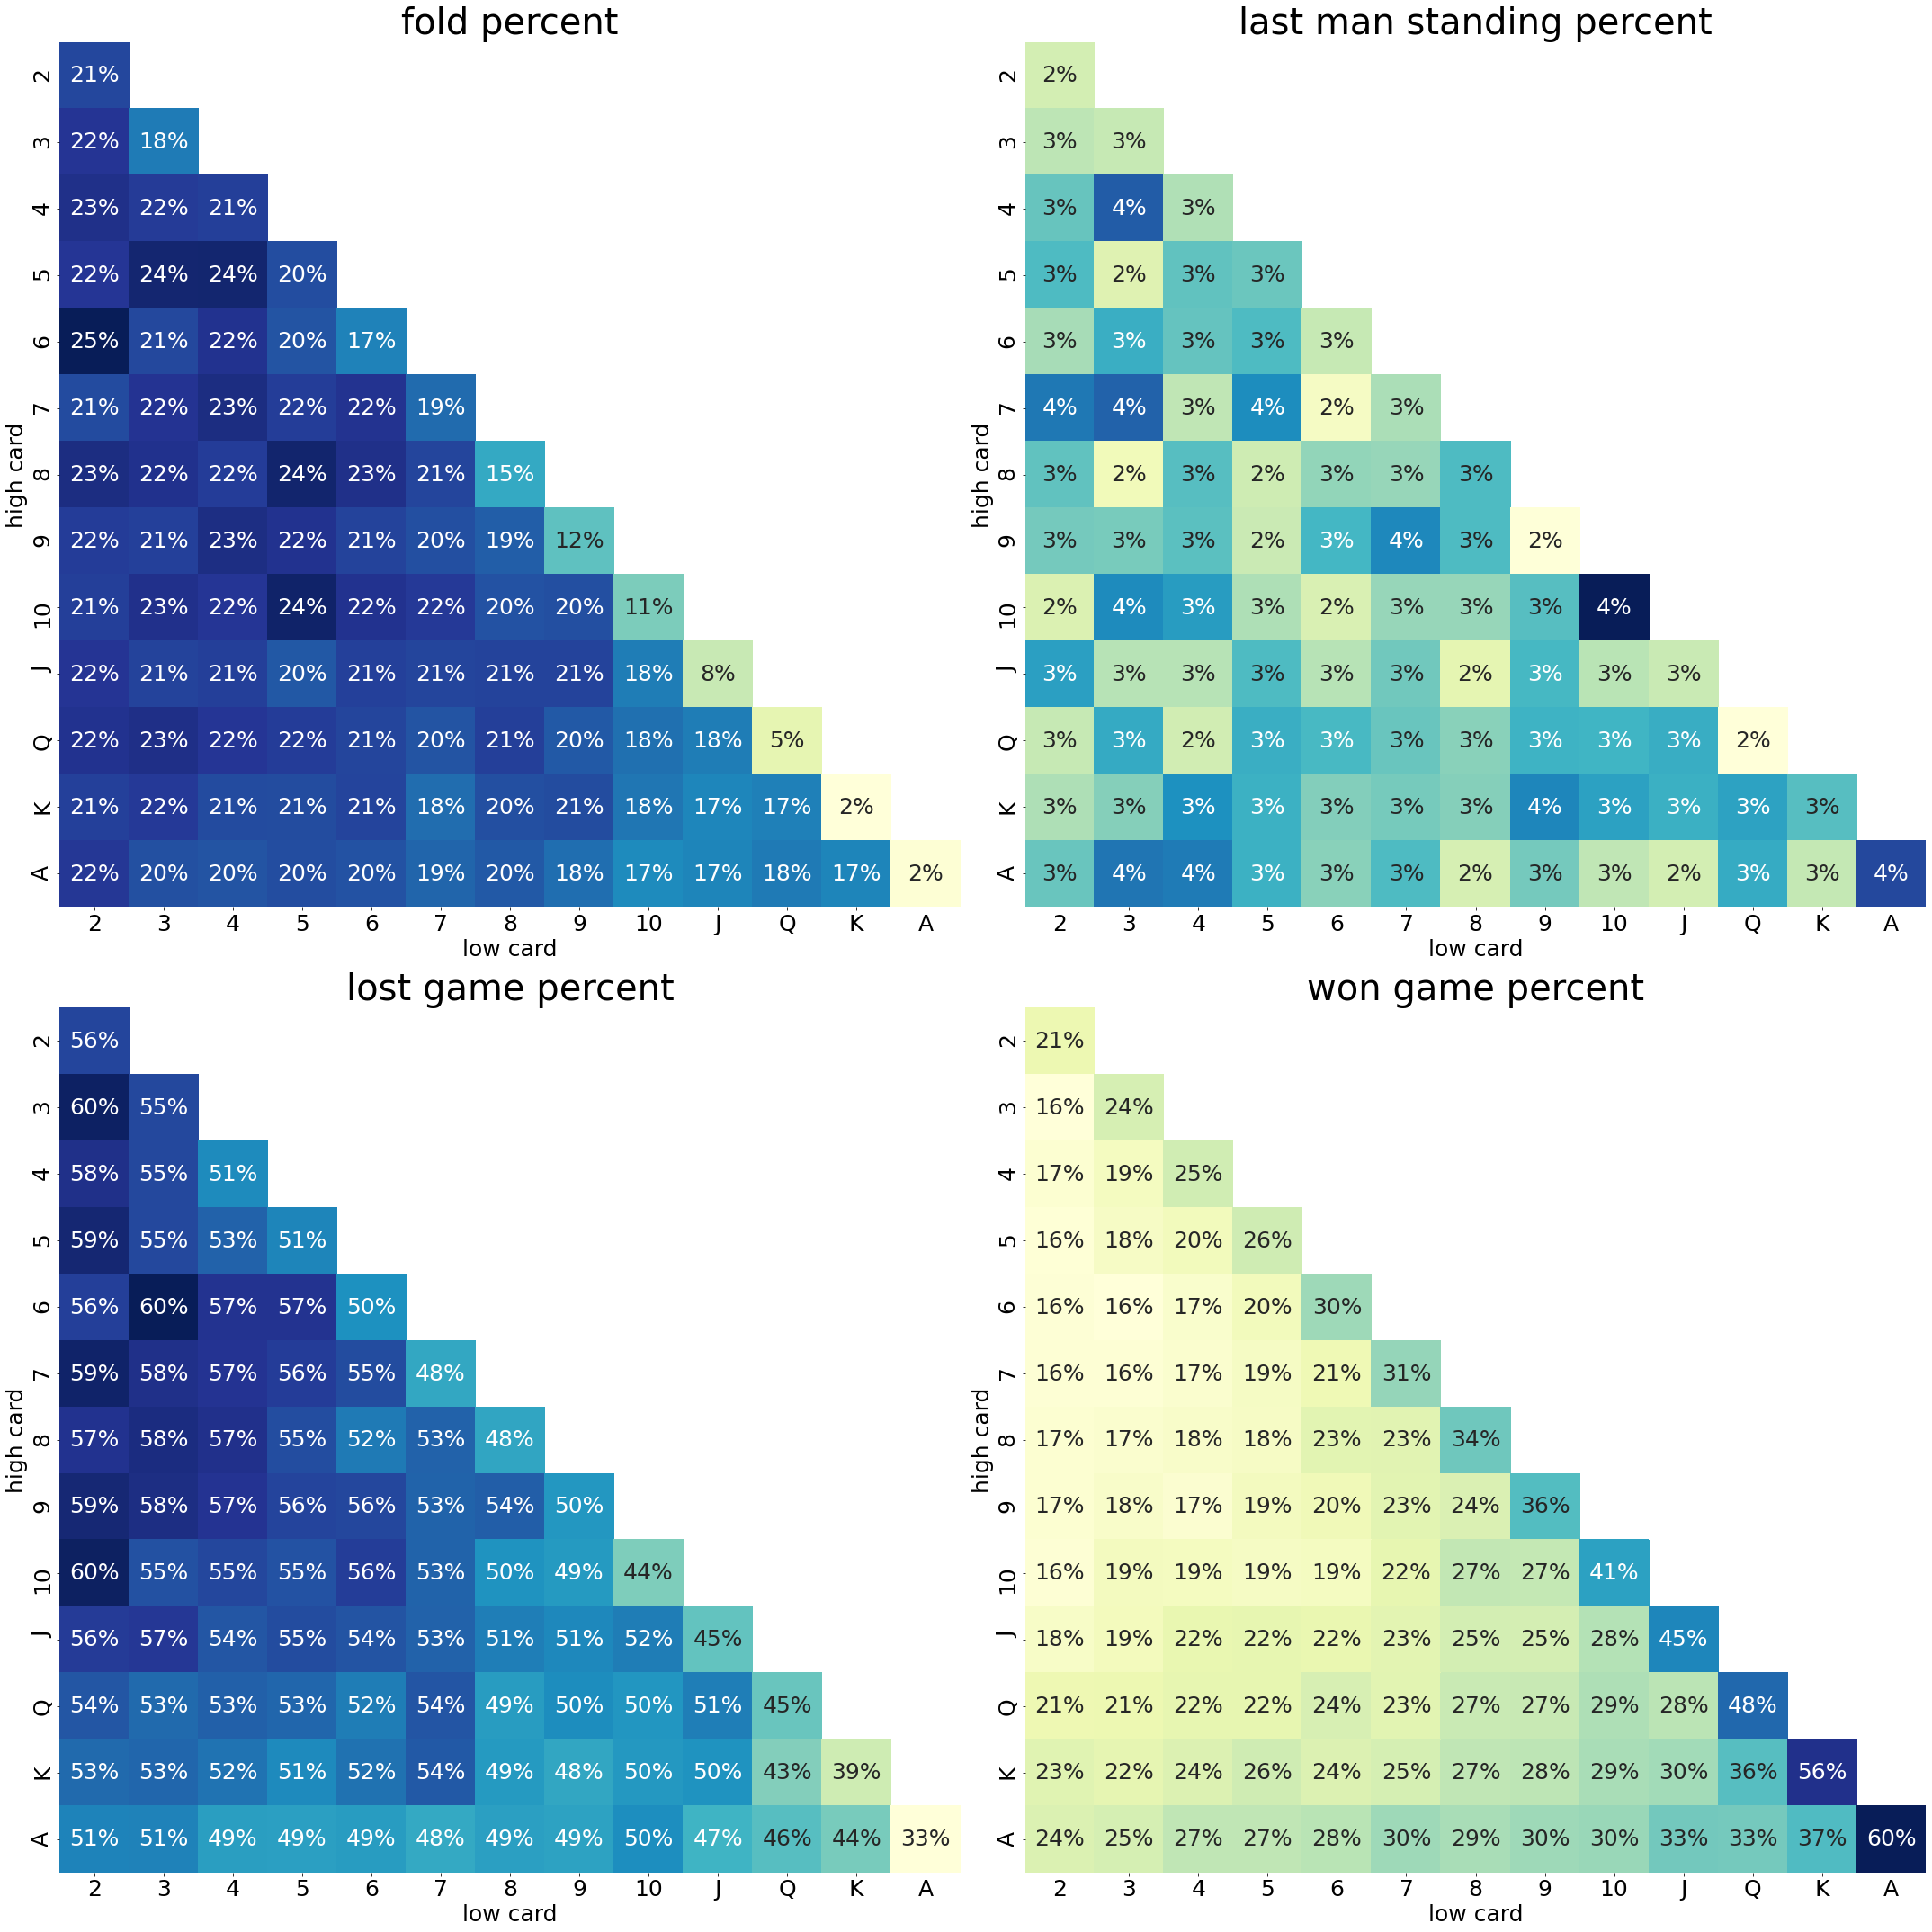

In [19]:
fig, axis = plt.subplots(2,2,figsize=(30, 30))

percentages = game_stats[['rank1','rank2'] + [c for c in game_stats.columns if c.endswith('percent')]].sort_values(['won_game_percent','last_man_standing_percent','fold_percent','lost_game_percent'],ascending=False)

all_axis = []

for row in axis:
    for col in row:
        all_axis.append(col)
        
rank_order = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']

plot_num = 0
for percent in [c for c in percentages.columns if c.endswith('percent')]:
    ax = all_axis[plot_num]
    percents_pivot = percentages.pivot(index='rank2',columns='rank1',values=percent)
    percents_pivot = percents_pivot.loc[rank_order,rank_order]
    sns.heatmap(percents_pivot, annot = True, ax = ax,cmap="YlGnBu",fmt=".0%", annot_kws={'size': 25}, cbar=False)
    ax.set_title(percent.replace('_',' '),fontsize=40)
    ax.set_xlabel('low card',fontsize=25)
    ax.set_ylabel('high card',fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plot_num += 1
    
plt.tight_layout()

In [20]:
per_game_type = analysis_data.groupby(['rank1','rank2','same_suit','game_reason']).category.count().reset_index()
games_total = analysis_data.groupby(['rank1','rank2','same_suit',]).game_net_change.count().reset_index()
pre_flop_data = pd.merge(per_game_type,games_total).sort_values(['rank1','rank2','same_suit'])
game_stats = pre_flop_data.pivot(index =['rank1','rank2','game_net_change','same_suit'], columns = ['game_reason'], values =['category']).reset_index()
game_stats.columns = [c[1] if c[1] else c[0] for c in game_stats.columns]
game_stats = game_stats.fillna(0)
game_stats['fold_percent'] = game_stats['fold'] / game_stats['game_net_change']
game_stats['last_man_standing_percent'] = game_stats['last_man_standing'] / game_stats['game_net_change']
game_stats['lost_game_percent'] = game_stats['lost_game'] / game_stats['game_net_change']
game_stats['won_game_percent'] = game_stats['won_game'] / game_stats['game_net_change']
game_stats

rank1 rank2  game_net_change  same_suit  fold  last_man_standing  \
0      10    10              540      False    58                 24   
1      10     A              368       True    53                 12   
2      10     A             1115      False   195                 26   
3      10     J              364       True    67                 11   
4      10     J             1066      False   184                 26   
..    ...   ...              ...        ...   ...                ...   
164     Q     A              356       True    57                 12   
165     Q     A             1055      False   193                 34   
166     Q     K              384       True    48                 16   
167     Q     K             1083      False   207                 33   
168     Q     Q              531      False    29                 10   

     lost_game  won_game  fold_percent  last_man_standing_percent  \
0          235       223       0.10741                    0.04444   
1          168       135       0.14402                    0.03261   
2          580       314       0.17489                    0.02332   
3          179       107       0.18407                    0.03022   
4          558       298       0.17261                    0.02439   
..         ...       ...           ...                        ...   
164        155       132       0.16011                    0.03371   
165        489       339       0.18294                    0.03223   
166        174       146       0.12500                    0.04167   
167        461       382       0.19114                    0.03047   
168        237       255       0.05461                    0.01883   

     lost_game_percent  won_game_percent  
0              0.43519           0.41296  
1              0.45652           0.36685  
2              0.52018           0.28161  
3              0.49176           0.29396  
4              0.52345           0.27955  
..                 ...               ...  
164            0.43539           0.37079  
165            0.46351           0.32133  
166            0.45312           0.38021  
167            0.42567           0.35272  
168            0.44633           0.48023  

[169 rows x 12 columns]

0.2511137180254419
0.2796002343291766


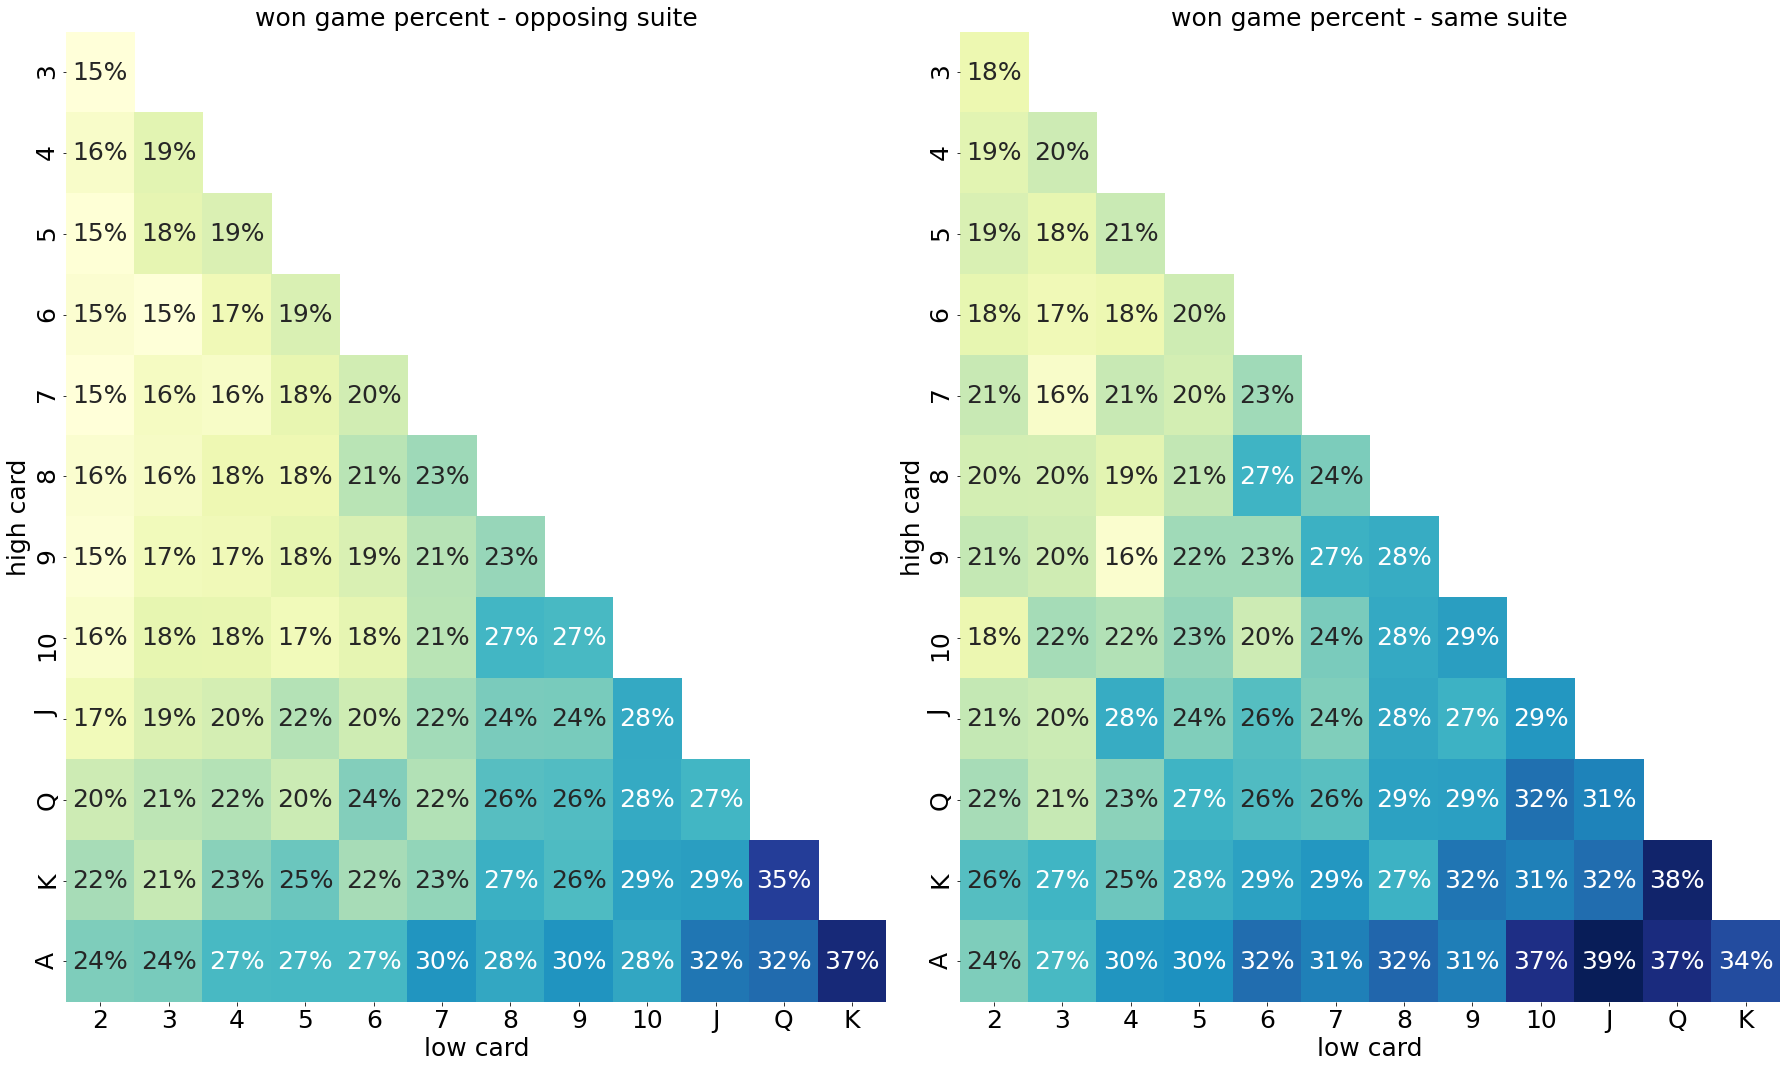

In [21]:
fig, axis = plt.subplots(1,2,figsize=(25, 15))

percentages = game_stats[['rank1','rank2','same_suit','won_game_percent']]

all_axis = []

for row in axis:
    all_axis.append(row)
        
rank_order = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']

max_val = percentages.query("rank1 != rank2").won_game_percent.max()
min_val = percentages.query("rank1 != rank2").won_game_percent.min()

plot_num = 0
for suite_type, percent in ((False,'won_game_percent'),(True,'won_game_percent')):
    ax = all_axis[plot_num]
    filtered_percentages = percentages.query('same_suit == {} and rank1 != rank2'.format(suite_type))
    rank1_order = [rank for rank in rank_order if rank in set(filtered_percentages['rank1'].to_list())]
    rank2_order = [rank for rank in rank_order if rank in set(filtered_percentages['rank2'].to_list())]
    percents_pivot = filtered_percentages.pivot(index='rank2',columns='rank1',values=percent)
    percents_pivot = percents_pivot.loc[rank2_order,rank1_order]
    sns.heatmap(percents_pivot, annot = True, ax = ax,cmap="YlGnBu",fmt=".0%",vmax=max_val, vmin=min_val, annot_kws={'size': 25}, cbar=False)
    ax.set_title(percent.replace('_',' ') + ' - ' + ('same suite' if suite_type else 'opposing suite'),fontsize=25)
    ax.set_xlabel('low card',fontsize=25)
    ax.set_ylabel('high card',fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plot_num += 1
    print(percents_pivot.mean().mean())
    
plt.tight_layout()

In [22]:
24 - 16

8

In [23]:
per_game_type = analysis_data.groupby(['player_type','rank1','rank2','same_suit','game_reason']).category.count().reset_index()
games_total = analysis_data.groupby(['player_type','rank1','rank2','same_suit',]).game_net_change.count().reset_index()
pre_flop_data = pd.merge(per_game_type,games_total).sort_values(['player_type','rank1','rank2','same_suit'])
game_stats = pre_flop_data.pivot(index =['player_type','rank1','rank2','game_net_change','same_suit'], columns = ['game_reason'], values =['category']).reset_index()
game_stats.columns = [c[1] if c[1] else c[0] for c in game_stats.columns]
game_stats = game_stats.fillna(0)
game_stats['fold_percent'] = game_stats['fold'] / game_stats['game_net_change']
game_stats['last_man_standing_percent'] = game_stats['last_man_standing'] / game_stats['game_net_change']
game_stats['lost_game_percent'] = game_stats['lost_game'] / game_stats['game_net_change']
game_stats['won_game_percent'] = game_stats['won_game'] / game_stats['game_net_change']
game_stats

player_type rank1 rank2  game_net_change  same_suit     fold  \
0    AlwaysCallPlayer    10    10              403      False  0.00000   
1    AlwaysCallPlayer    10     A              280       True  0.00000   
2    AlwaysCallPlayer    10     A              845      False  0.00000   
3    AlwaysCallPlayer    10     J              271       True  0.00000   
4    AlwaysCallPlayer    10     J              827      False  0.00000   
..                ...   ...   ...              ...        ...      ...   
502       SmartPlayer     Q     A               46       True 20.00000   
503       SmartPlayer     Q     A              117      False 53.00000   
504       SmartPlayer     Q     K               46       True 16.00000   
505       SmartPlayer     Q     K              135      False 69.00000   
506       SmartPlayer     Q     Q               76      False  9.00000   

     last_man_standing  lost_game  won_game  fold_percent  \
0             24.00000  205.00000 174.00000       0.00000   
1             12.00000  156.00000 112.00000       0.00000   
2             26.00000  550.00000 269.00000       0.00000   
3             11.00000  172.00000  88.00000       0.00000   
4             26.00000  540.00000 261.00000       0.00000   
..                 ...        ...       ...           ...   
502            0.00000   12.00000  14.00000       0.43478   
503            0.00000   26.00000  38.00000       0.45299   
504            0.00000   12.00000  18.00000       0.34783   
505            0.00000   24.00000  42.00000       0.51111   
506            0.00000   32.00000  35.00000       0.11842   

     last_man_standing_percent  lost_game_percent  won_game_percent  
0                      0.05955            0.50868           0.43176  
1                      0.04286            0.55714           0.40000  
2                      0.03077            0.65089           0.31834  
3                      0.04059            0.63469           0.32472  
4                      0.03144            0.65296           0.31560  
..                         ...                ...               ...  
502                    0.00000            0.26087           0.30435  
503                    0.00000            0.22222           0.32479  
504                    0.00000            0.26087           0.39130  
505                    0.00000            0.17778           0.31111  
506                    0.00000            0.42105           0.46053  

[507 rows x 13 columns]

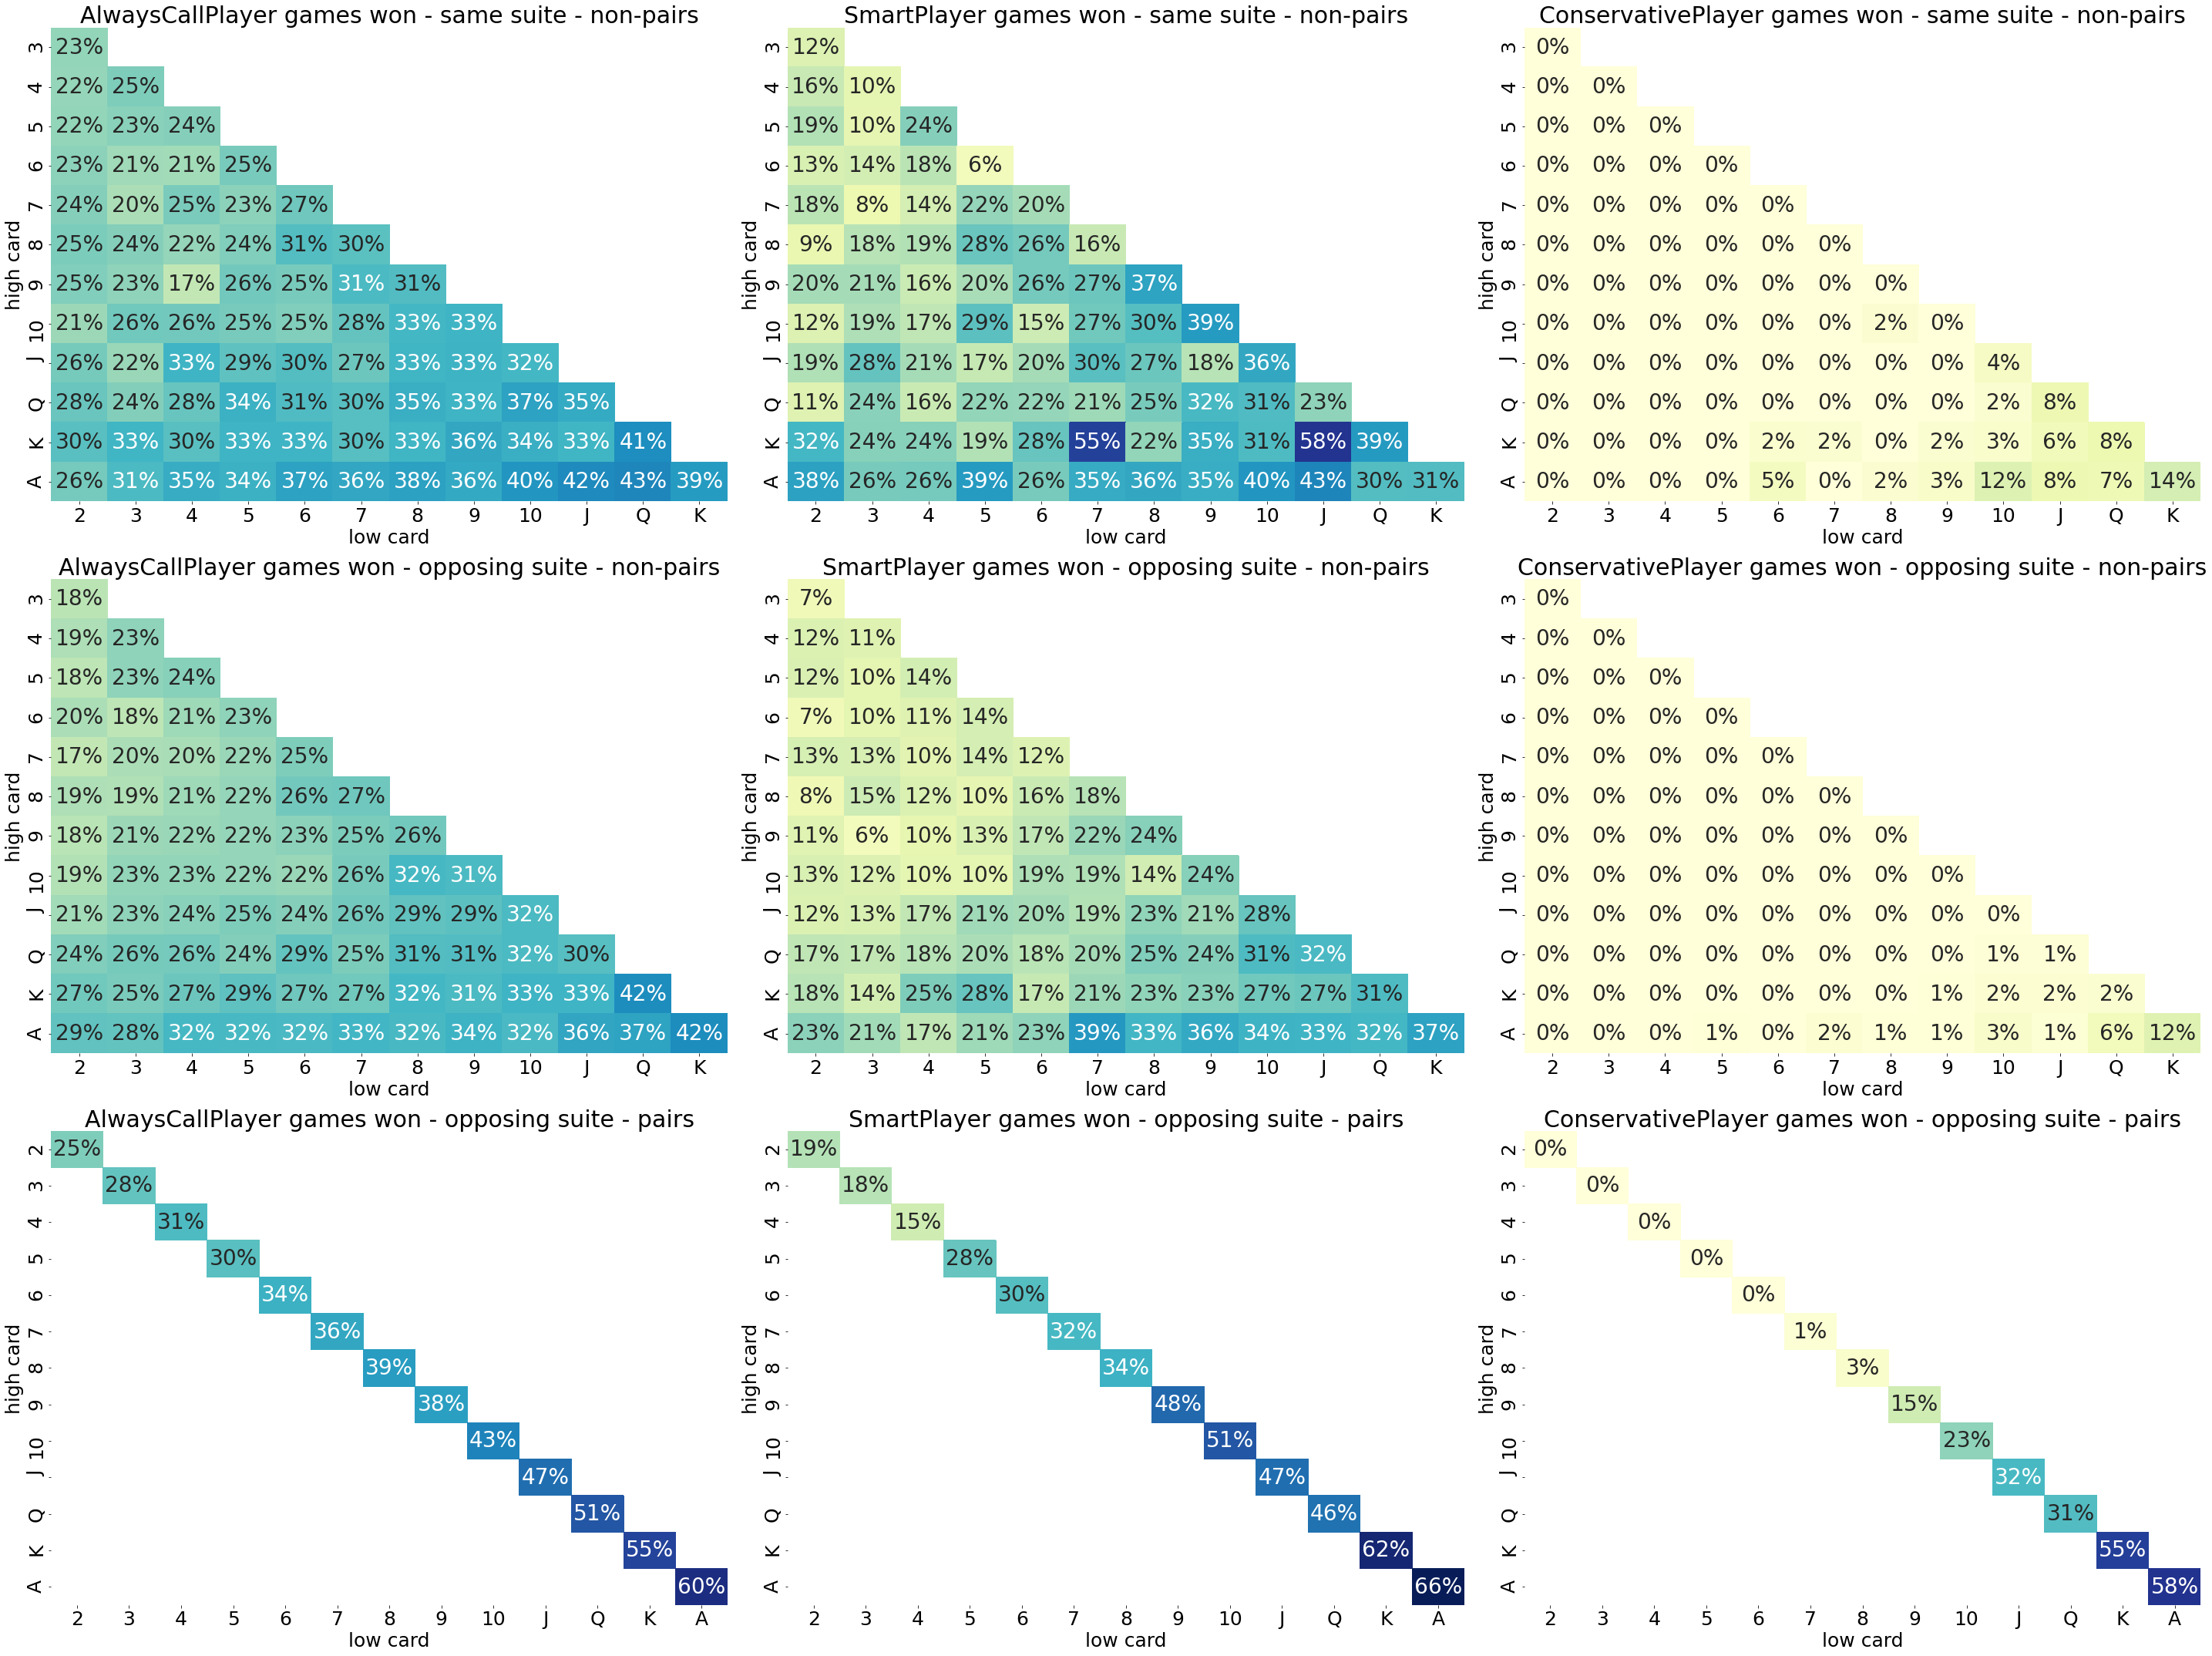

In [24]:
fig, axis = plt.subplots(3,3,figsize=(40, 30))

percentages = game_stats[['player_type','same_suit','rank1','rank2'] + [c for c in game_stats.columns if c.endswith('percent')]].sort_values(['won_game_percent','last_man_standing_percent','fold_percent','lost_game_percent'],ascending=False)

all_axis = []

for row in axis:
    for col in row:
        all_axis.append(col)

rank_order = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']

suite_options = [True, False,False]
rank_options = [False,False,True]
player_type_options = ['AlwaysCallPlayer','SmartPlayer','ConservativePlayer']
options = [(suit, rank, player_type, 'won_game_percent') for suit,rank in zip(suite_options,rank_options) for player_type in player_type_options]

max_val = percentages.won_game_percent.max()
min_val = percentages.won_game_percent.min()

plot_num = 0
for suite_type,rank_type, player_type, percent in options:
    ax = all_axis[plot_num]
    if rank_type:
        query = 'same_suit == {} and player_type == "{}" and rank1 == rank2'.format(suite_type,player_type)
    else:
        query = 'same_suit == {} and player_type == "{}" and rank1 != rank2'.format(suite_type,player_type)
    filtered_percentages = percentages.query(query)
    rank1_order = [rank for rank in rank_order if rank in set(filtered_percentages['rank1'].to_list())]
    rank2_order = [rank for rank in rank_order if rank in set(filtered_percentages['rank2'].to_list())]
    percents_pivot = filtered_percentages.pivot(index='rank2',columns='rank1',values=percent)
    percents_pivot = percents_pivot.loc[rank2_order,rank1_order]
    sns.heatmap(percents_pivot, annot = True, ax = ax,cmap="YlGnBu",fmt=".0%",vmax=max_val, vmin=min_val, annot_kws={'size': 28}, cbar=False)
    title = player_type + ' games won - ' + ('same suite - ' if suite_type else 'opposing suite - ') + ('pairs' if rank_type else 'non-pairs') 
    ax.set_title(title,fontsize=30)
    ax.set_xlabel('low card',fontsize=25)
    ax.set_ylabel('high card',fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plot_num += 1
    
plt.tight_layout()

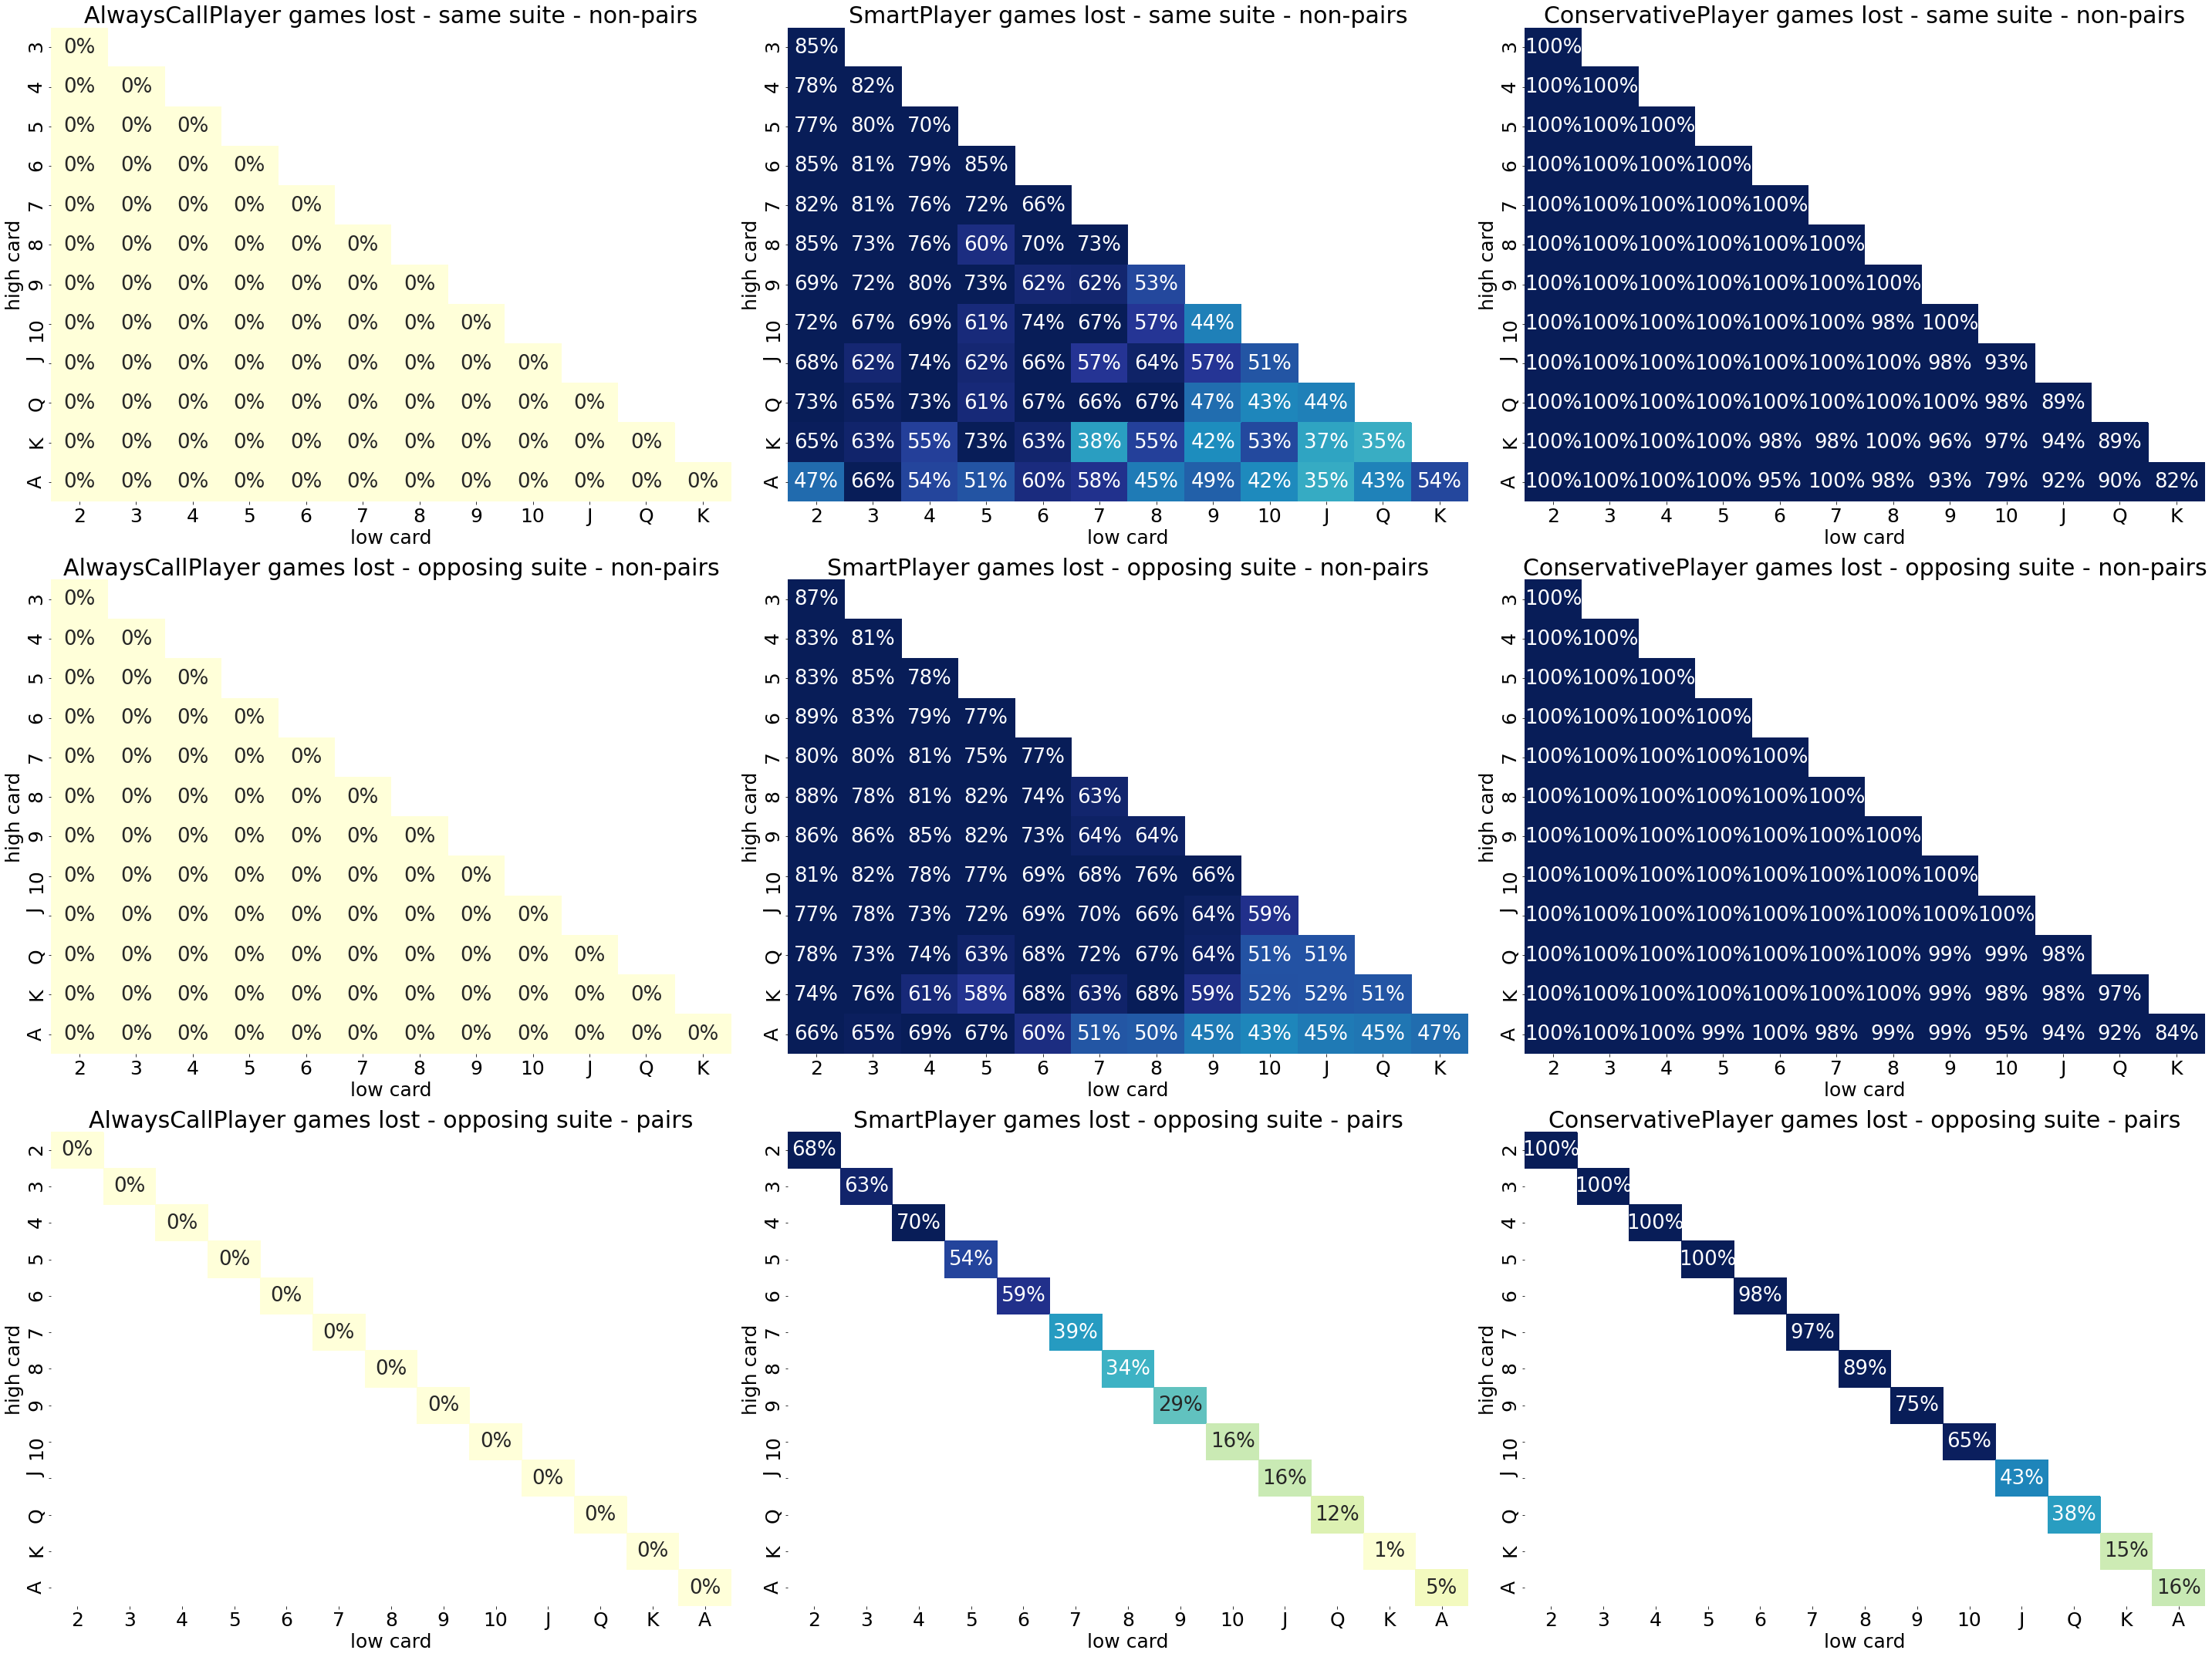

In [27]:
fig, axis = plt.subplots(3,3,figsize=(40, 30))

percentages = game_stats[['player_type','same_suit','rank1','rank2'] + [c for c in game_stats.columns if c.endswith('percent')]].sort_values(['won_game_percent','last_man_standing_percent','fold_percent','lost_game_percent'],ascending=False)

all_axis = []

for row in axis:
    for col in row:
        all_axis.append(col)

rank_order = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']

suite_options = [True, False,False]
rank_options = [False,False,True]
player_type_options = ['AlwaysCallPlayer','SmartPlayer','ConservativePlayer']
options = [(suit, rank, player_type, 'fold_percent') for suit,rank in zip(suite_options,rank_options) for player_type in player_type_options]

max_val = percentages.won_game_percent.max()
min_val = percentages.won_game_percent.min()

plot_num = 0
for suite_type,rank_type, player_type, percent in options:
    ax = all_axis[plot_num]
    if rank_type:
        query = 'same_suit == {} and player_type == "{}" and rank1 == rank2'.format(suite_type,player_type)
    else:
        query = 'same_suit == {} and player_type == "{}" and rank1 != rank2'.format(suite_type,player_type)
    filtered_percentages = percentages.query(query)
    rank1_order = [rank for rank in rank_order if rank in set(filtered_percentages['rank1'].to_list())]
    rank2_order = [rank for rank in rank_order if rank in set(filtered_percentages['rank2'].to_list())]
    percents_pivot = filtered_percentages.pivot(index='rank2',columns='rank1',values=percent)
    percents_pivot = percents_pivot.loc[rank2_order,rank1_order]
    sns.heatmap(percents_pivot, annot = True, ax = ax,cmap="YlGnBu",fmt=".0%",vmax=max_val, vmin=min_val, annot_kws={'size': 26}, cbar=False)
    title = player_type + ' games folded - ' + ('same suite - ' if suite_type else 'opposing suite - ') + ('pairs' if rank_type else 'non-pairs') 
    ax.set_title(title,fontsize=30)
    ax.set_xlabel('low card',fontsize=25)
    ax.set_ylabel('high card',fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plot_num += 1
    
plt.tight_layout()

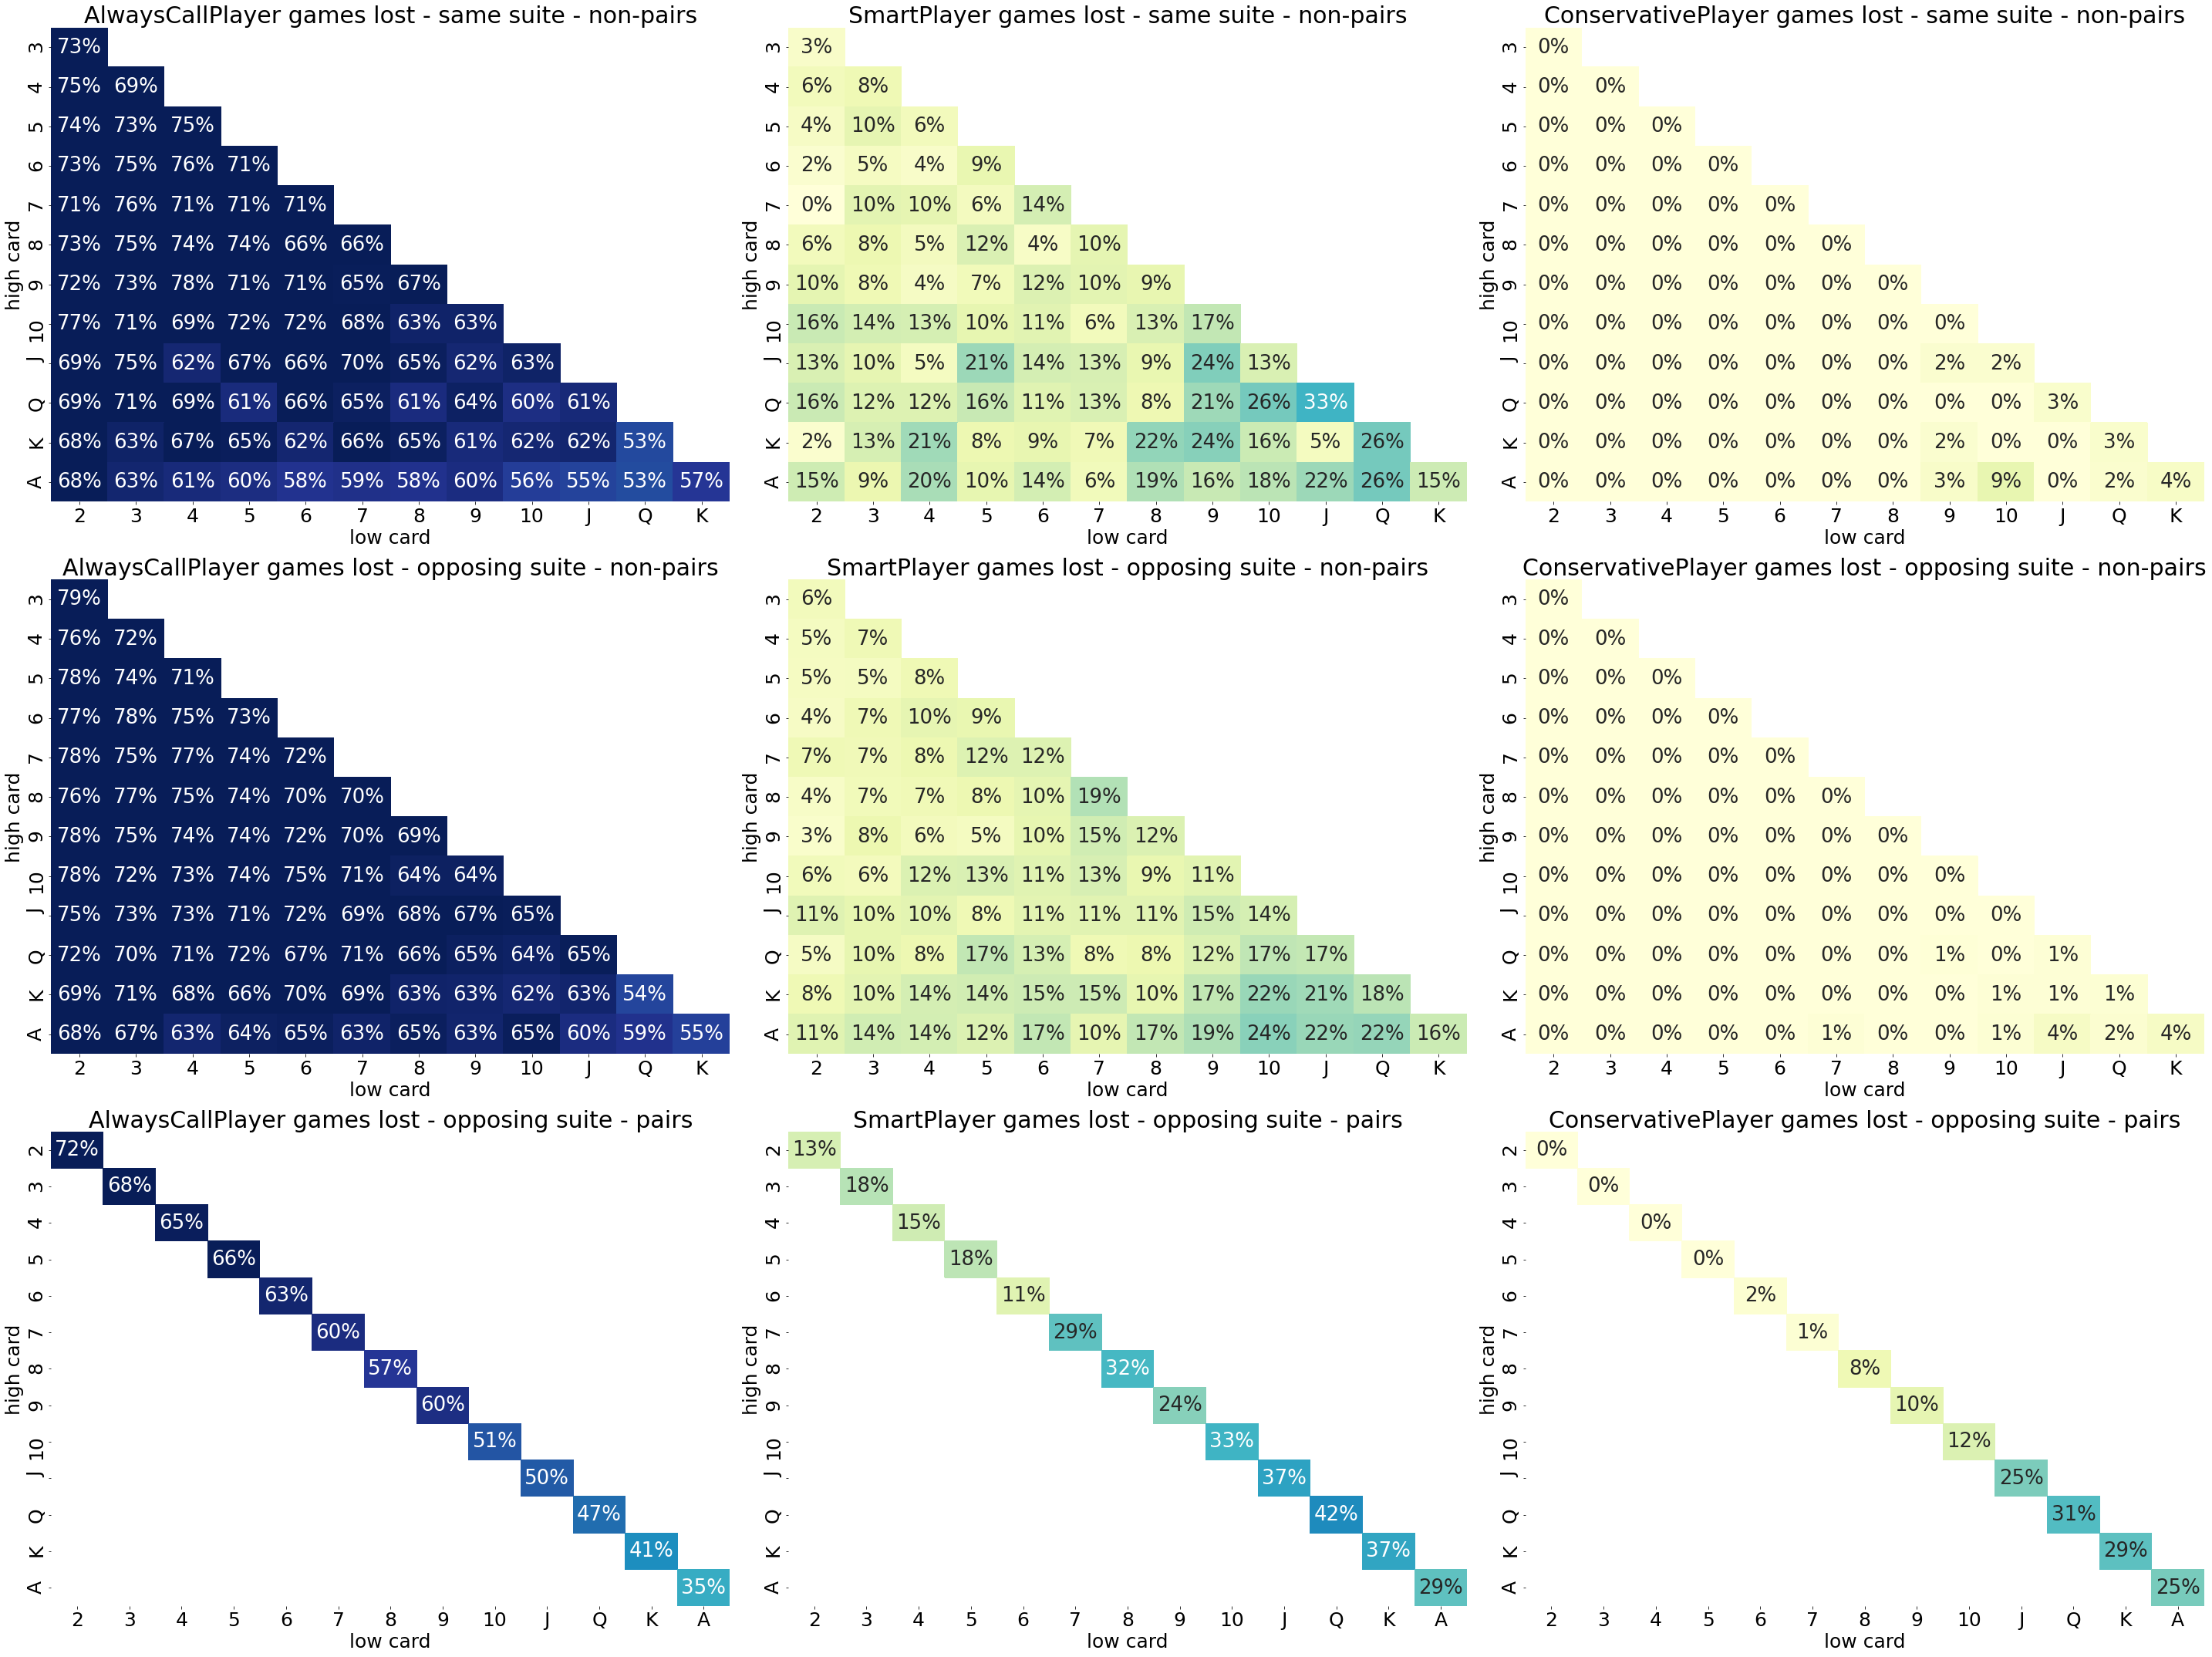

In [29]:
fig, axis = plt.subplots(3,3,figsize=(40, 30))

percentages = game_stats[['player_type','same_suit','rank1','rank2'] + [c for c in game_stats.columns if c.endswith('percent')]].sort_values(['won_game_percent','last_man_standing_percent','fold_percent','lost_game_percent'],ascending=False)

all_axis = []

for row in axis:
    for col in row:
        all_axis.append(col)

rank_order = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']

suite_options = [True, False,False]
rank_options = [False,False,True]
player_type_options = ['AlwaysCallPlayer','SmartPlayer','ConservativePlayer']
options = [(suit, rank, player_type, 'lost_game_percent') for suit,rank in zip(suite_options,rank_options) for player_type in player_type_options]

max_val = percentages.won_game_percent.max()
min_val = percentages.won_game_percent.min()

plot_num = 0
for suite_type,rank_type, player_type, percent in options:
    ax = all_axis[plot_num]
    if rank_type:
        query = 'same_suit == {} and player_type == "{}" and rank1 == rank2'.format(suite_type,player_type)
    else:
        query = 'same_suit == {} and player_type == "{}" and rank1 != rank2'.format(suite_type,player_type)
    filtered_percentages = percentages.query(query)
    rank1_order = [rank for rank in rank_order if rank in set(filtered_percentages['rank1'].to_list())]
    rank2_order = [rank for rank in rank_order if rank in set(filtered_percentages['rank2'].to_list())]
    percents_pivot = filtered_percentages.pivot(index='rank2',columns='rank1',values=percent)
    percents_pivot = percents_pivot.loc[rank2_order,rank1_order]
    sns.heatmap(percents_pivot, annot = True, ax = ax,cmap="YlGnBu",fmt=".0%",vmax=max_val, vmin=min_val, annot_kws={'size': 26}, cbar=False)
    title = player_type + ' games lost - ' + ('same suite - ' if suite_type else 'opposing suite - ') + ('pairs' if rank_type else 'non-pairs') 
    ax.set_title(title,fontsize=30)
    ax.set_xlabel('low card',fontsize=25)
    ax.set_ylabel('high card',fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plot_num += 1
    
plt.tight_layout()